In [1]:
# Libraries

import numpy
import os
import platform
import shutil
import sys

In [2]:
# Ensure source path

ROOT = os.getcwd()

while not ROOT.endswith('upolanc-thesis') :
	ROOT = os.path.abspath(os.path.join(ROOT, os.pardir))

	if len(ROOT) < len('upolanc-thesis') :
		if   platform.system() == 'Linux' :
			ROOT = '/d/hpc/home/up4472/workspace/upolanc-thesis'
		elif platform.system() == 'Windows' :
			ROOT = 'C:\\Developer\\Workspace\\PyCharm\\Projects\\upolanc-thesis'
		else :
			raise ValueError()

		print(f'Warning : could not find correct directory, using default : {ROOT}')
		break

if ROOT not in sys.path :
	sys.path.append(ROOT)

os.chdir(ROOT)

In [3]:
# Code

from source.python.bert         import bert_data
from source.python.data.feature import feature_target
from source.python.dataset      import dataset_split
from source.python.io           import loader
from source.python.io           import writer
from source.python              import runtime

runtime.set_numpy_format()
runtime.set_pandas_format()
runtime.set_plot_theme()

# 1. Setup

In [4]:
# Setup some directory paths

FILTER_ID = 0
SUBFOLDER = 'filter' + str(FILTER_ID)

CWD = ROOT
OUT = os.path.join(CWD, 'output')
RES = os.path.join(CWD, 'resources')

OUT_DATA   = os.path.join(OUT,      'nbp05-target',  SUBFOLDER)
OUT_PLOT   = os.path.join(OUT_DATA, 'plot')
RES_NBP02  = os.path.join(OUT,      'nbp02-anndata', SUBFOLDER)
RES_NBP04  = os.path.join(OUT,      'nbp04-feature', SUBFOLDER)

shutil.rmtree(OUT_DATA, ignore_errors = True)

os.makedirs(OUT_DATA, exist_ok = True)
os.makedirs(OUT_PLOT, exist_ok = True)

print(f'     Root Directory : {CWD}')
print(f'   Output Directory : {OUT_DATA}')
print(f'   Output Directory : {OUT_PLOT}')
print(f' Resource Directory : {RES_NBP04}')

     Root Directory : C:\Developer\Workspace\PyCharm\Projects\upolanc-thesis
   Output Directory : C:\Developer\Workspace\PyCharm\Projects\upolanc-thesis\output\nbp05-target\filter0
   Output Directory : C:\Developer\Workspace\PyCharm\Projects\upolanc-thesis\output\nbp05-target\filter0\plot
 Resource Directory : C:\Developer\Workspace\PyCharm\Projects\upolanc-thesis\output\nbp04-feature\filter0


In [5]:
# Load the annotated and cleaned data

anndata = loader.load_h5ad(
	filename = os.path.join(RES_NBP04, 'arabidopsis-r36.h5ad')
)

sequence_promoter = loader.load_fasta(
	filename  = os.path.join(RES_NBP04, 'sequences-promoter.fasta'),
	to_string = True
)

sequence_bp2150 = loader.load_fasta(
	filename  = os.path.join(RES_NBP04, 'sequences-bp2150.fasta'),
	to_string = True
)

feature_base = loader.load_npz(
	filename = os.path.join(RES_NBP04, 'features-base.npz')
)

In [6]:
# Load anndata information

mapping_layer   = loader.load_json(filename = os.path.join(RES_NBP02, 'layer-mapping.json'))
factor_boxcox   = loader.load_json(filename = os.path.join(RES_NBP02, 'factors-boxcox.json'))
factor_normal   = loader.load_json(filename = os.path.join(RES_NBP02, 'factors-normal.json'))
factor_standard = loader.load_json(filename = os.path.join(RES_NBP02, 'factors-standard.json'))

In [7]:
# Constants

TARGET_LAYER = 'boxcox1p'
RANDOM_SEED  = runtime.lock_random(
	seed     = None,
	generate = True
)

print('Random Seed : {}'.format(RANDOM_SEED))

Random Seed : 365086696


# 2. Regression

In [8]:
# Extract the transcript tpm values

values, order = feature_target.extract_tpm_multi(
	data      = anndata,
	layer     = TARGET_LAYER,
	groups    = ['Tissue', 'Age', 'Group', 'Perturbation'],
	functions = [
		('max',  lambda x : numpy.max(x, axis = 0)),
		('mean', lambda x : numpy.mean(x, axis = 0))
	]
)

In [9]:
# Extend to include global mean per transcript

if TARGET_LAYER is None :
	matrix = anndata.X
else :
	matrix = anndata.layers[TARGET_LAYER]

for index, transcript in enumerate(anndata.var.index) :
	values[transcript]['global-mean'] = [matrix[:, index].mean()]
	values[transcript]['global-max']  = [matrix[:, index].max()]

order['global'] = ['global']

In [10]:
# Define what values to filter out (none means keep all)

filters = {
	'tissue'       : None,
	'age'          : None,
	'group'        : ['mature_leaf', 'mature_flower', 'mature_root', 'mature_seed', 'young_seedling'],
	'perturbation' : None
}

for key, keep in filters.items() :
	if keep is None :
		continue

	keep  = [x for x in keep if x in order[key]]
	index = [order[key].index(x) for x in keep]

	order[key] = keep

	for transcript in values.keys() :
		for group, array in values[transcript].items() :
			if not group.startswith(key.lower()) :
				continue

			values[transcript][group] = [array[x] for x in index]

In [11]:
# Display an example of the transcript tpm values

gene = anndata.var.index.to_list()[0]

for index, (key, value) in enumerate(values[gene].items()) :
	print(f'{key:17s} : [{len(value):2d}] ' + ' '.join('{:7.3f}'.format(x) for x in value))

tissue-max        : [ 5]   2.565   3.307   3.493   3.104   3.378
tissue-mean       : [ 5]   1.683   1.391   2.475   1.569   1.862
age-max           : [ 4]   3.339   3.307   2.045   3.493
age-mean          : [ 4]   1.644   1.845   1.490   2.111
group-max         : [ 5]   3.212   2.565   3.328   3.104   3.378
group-mean        : [ 5]   1.344   1.713   2.513   1.569   1.954
perturbation-max  : [ 7]   3.493   3.310   2.937   3.339   3.016   3.034   3.127
perturbation-mean : [ 7]   2.111   1.705   2.248   1.768   1.517   1.501   1.704
global-mean       : [ 1]   1.761
global-max        : [ 1]   3.493


## 2.1 Distributions

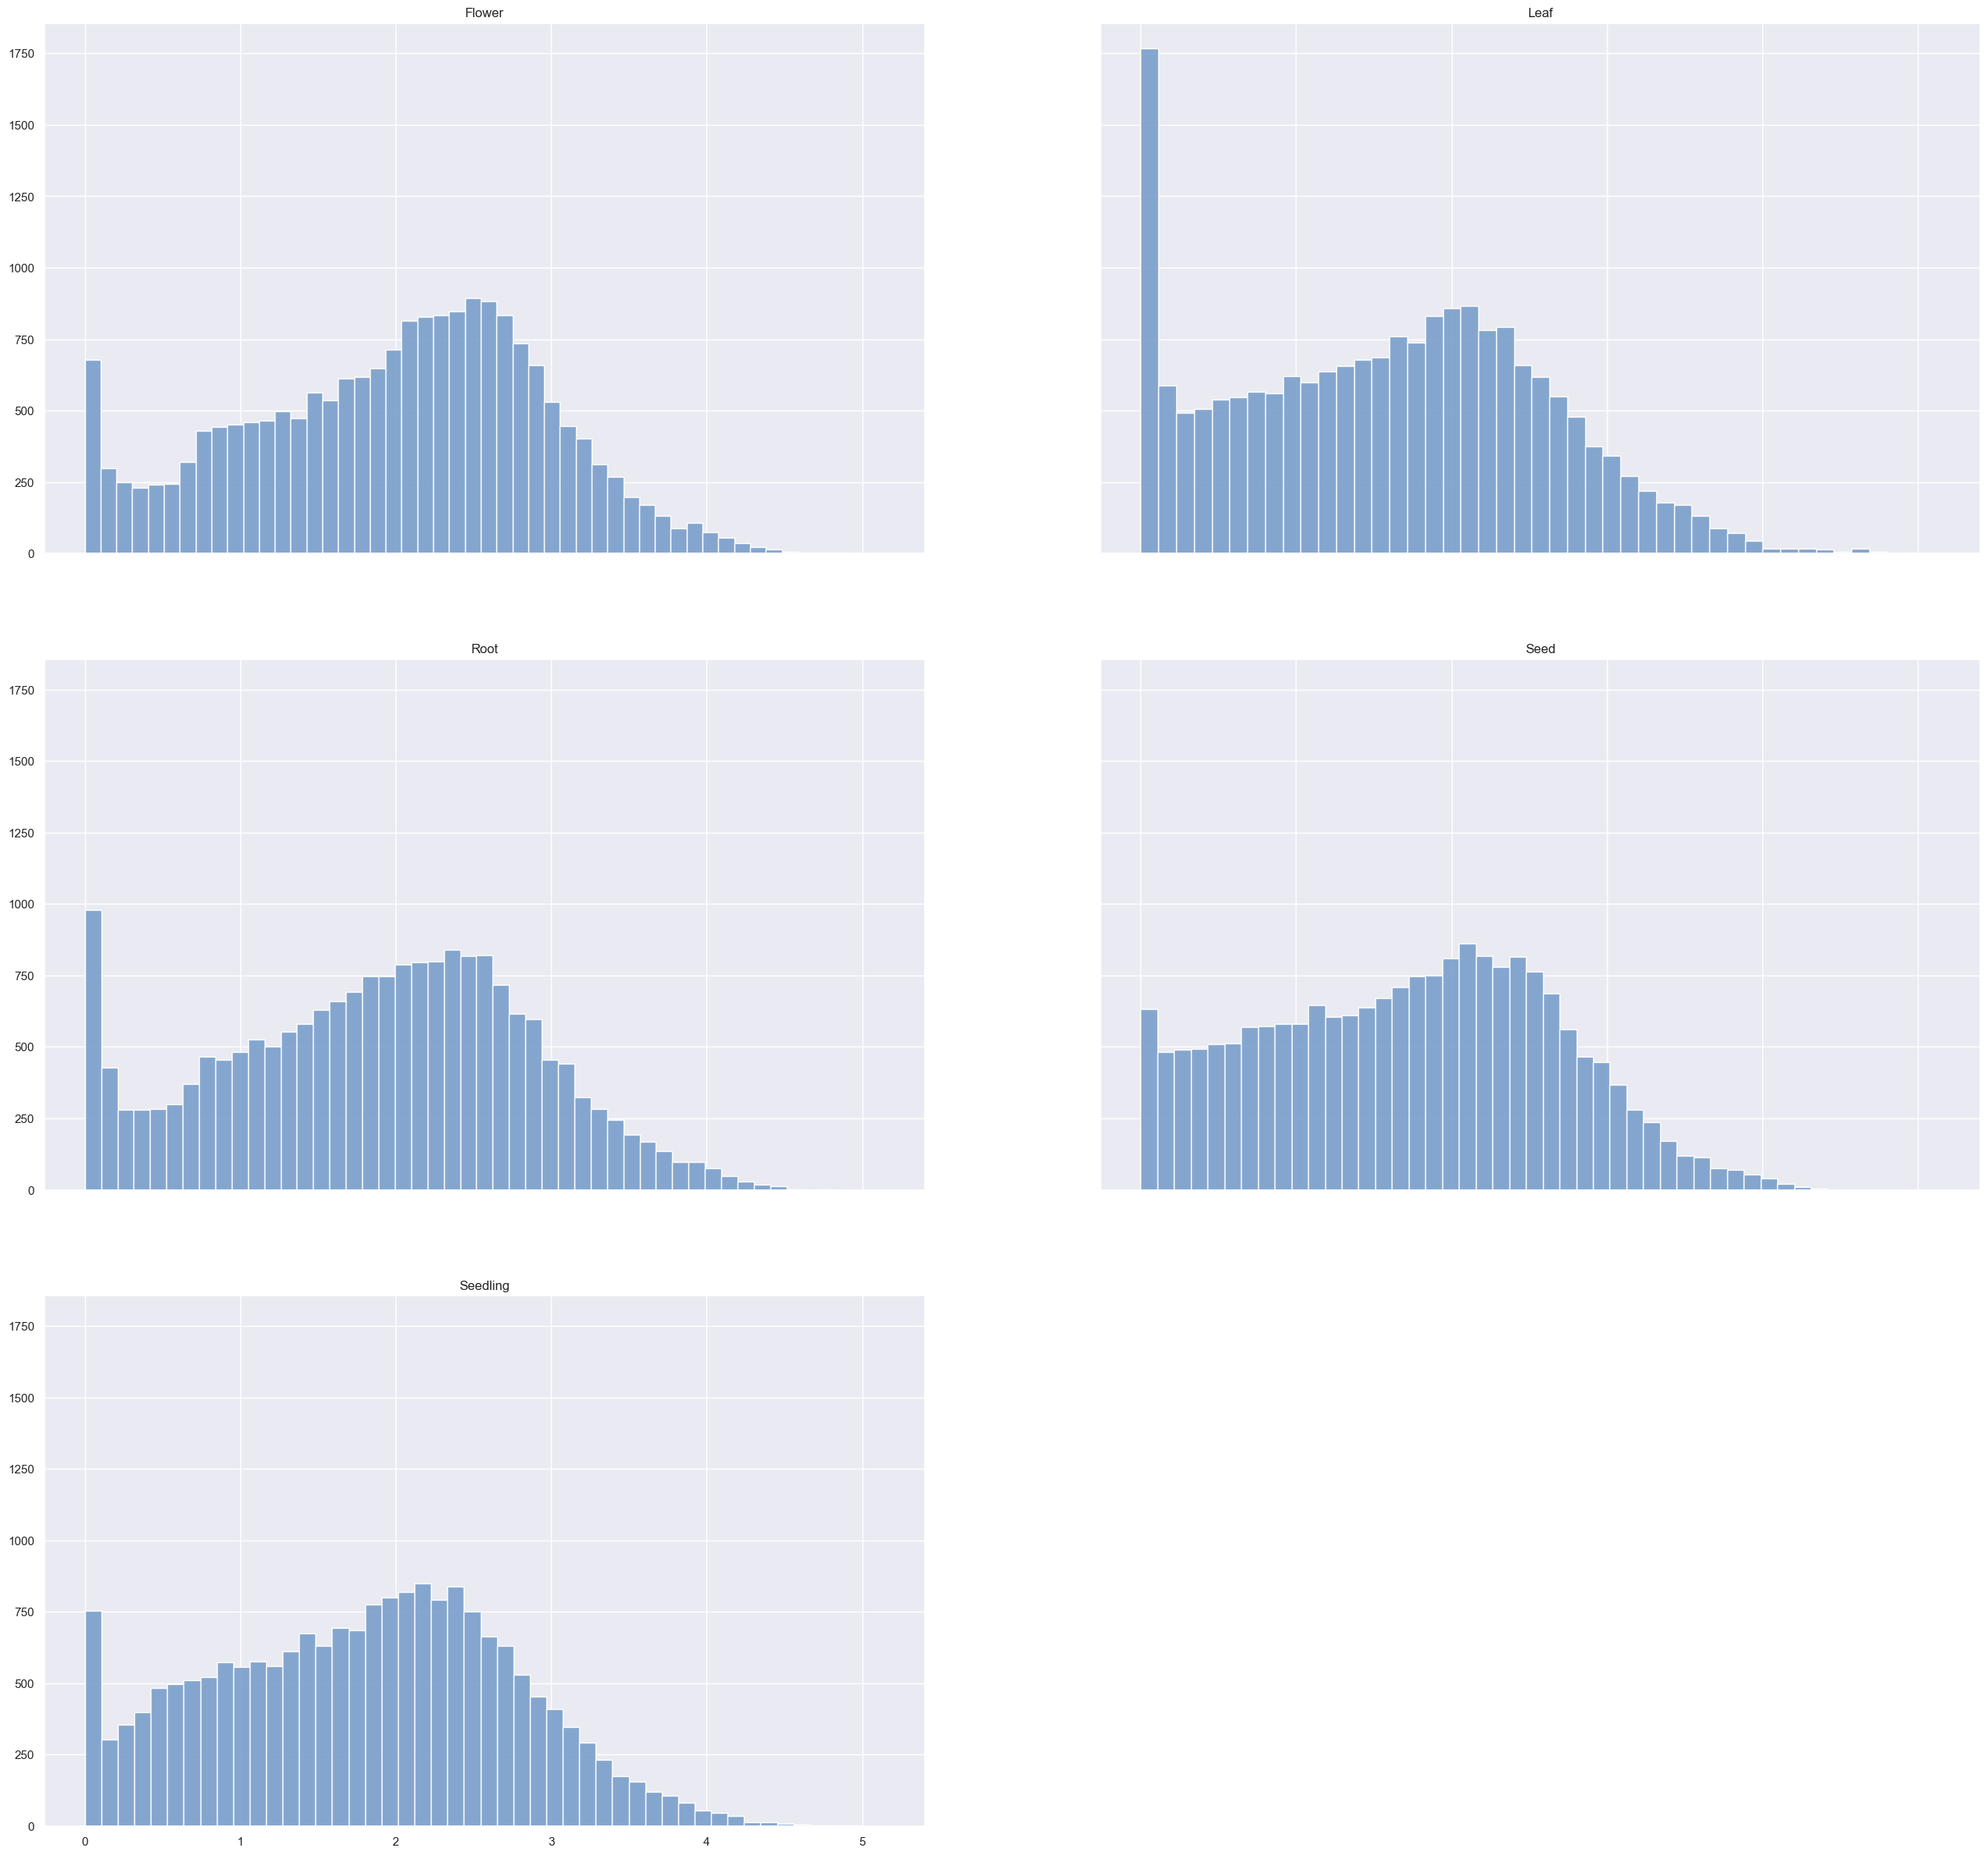

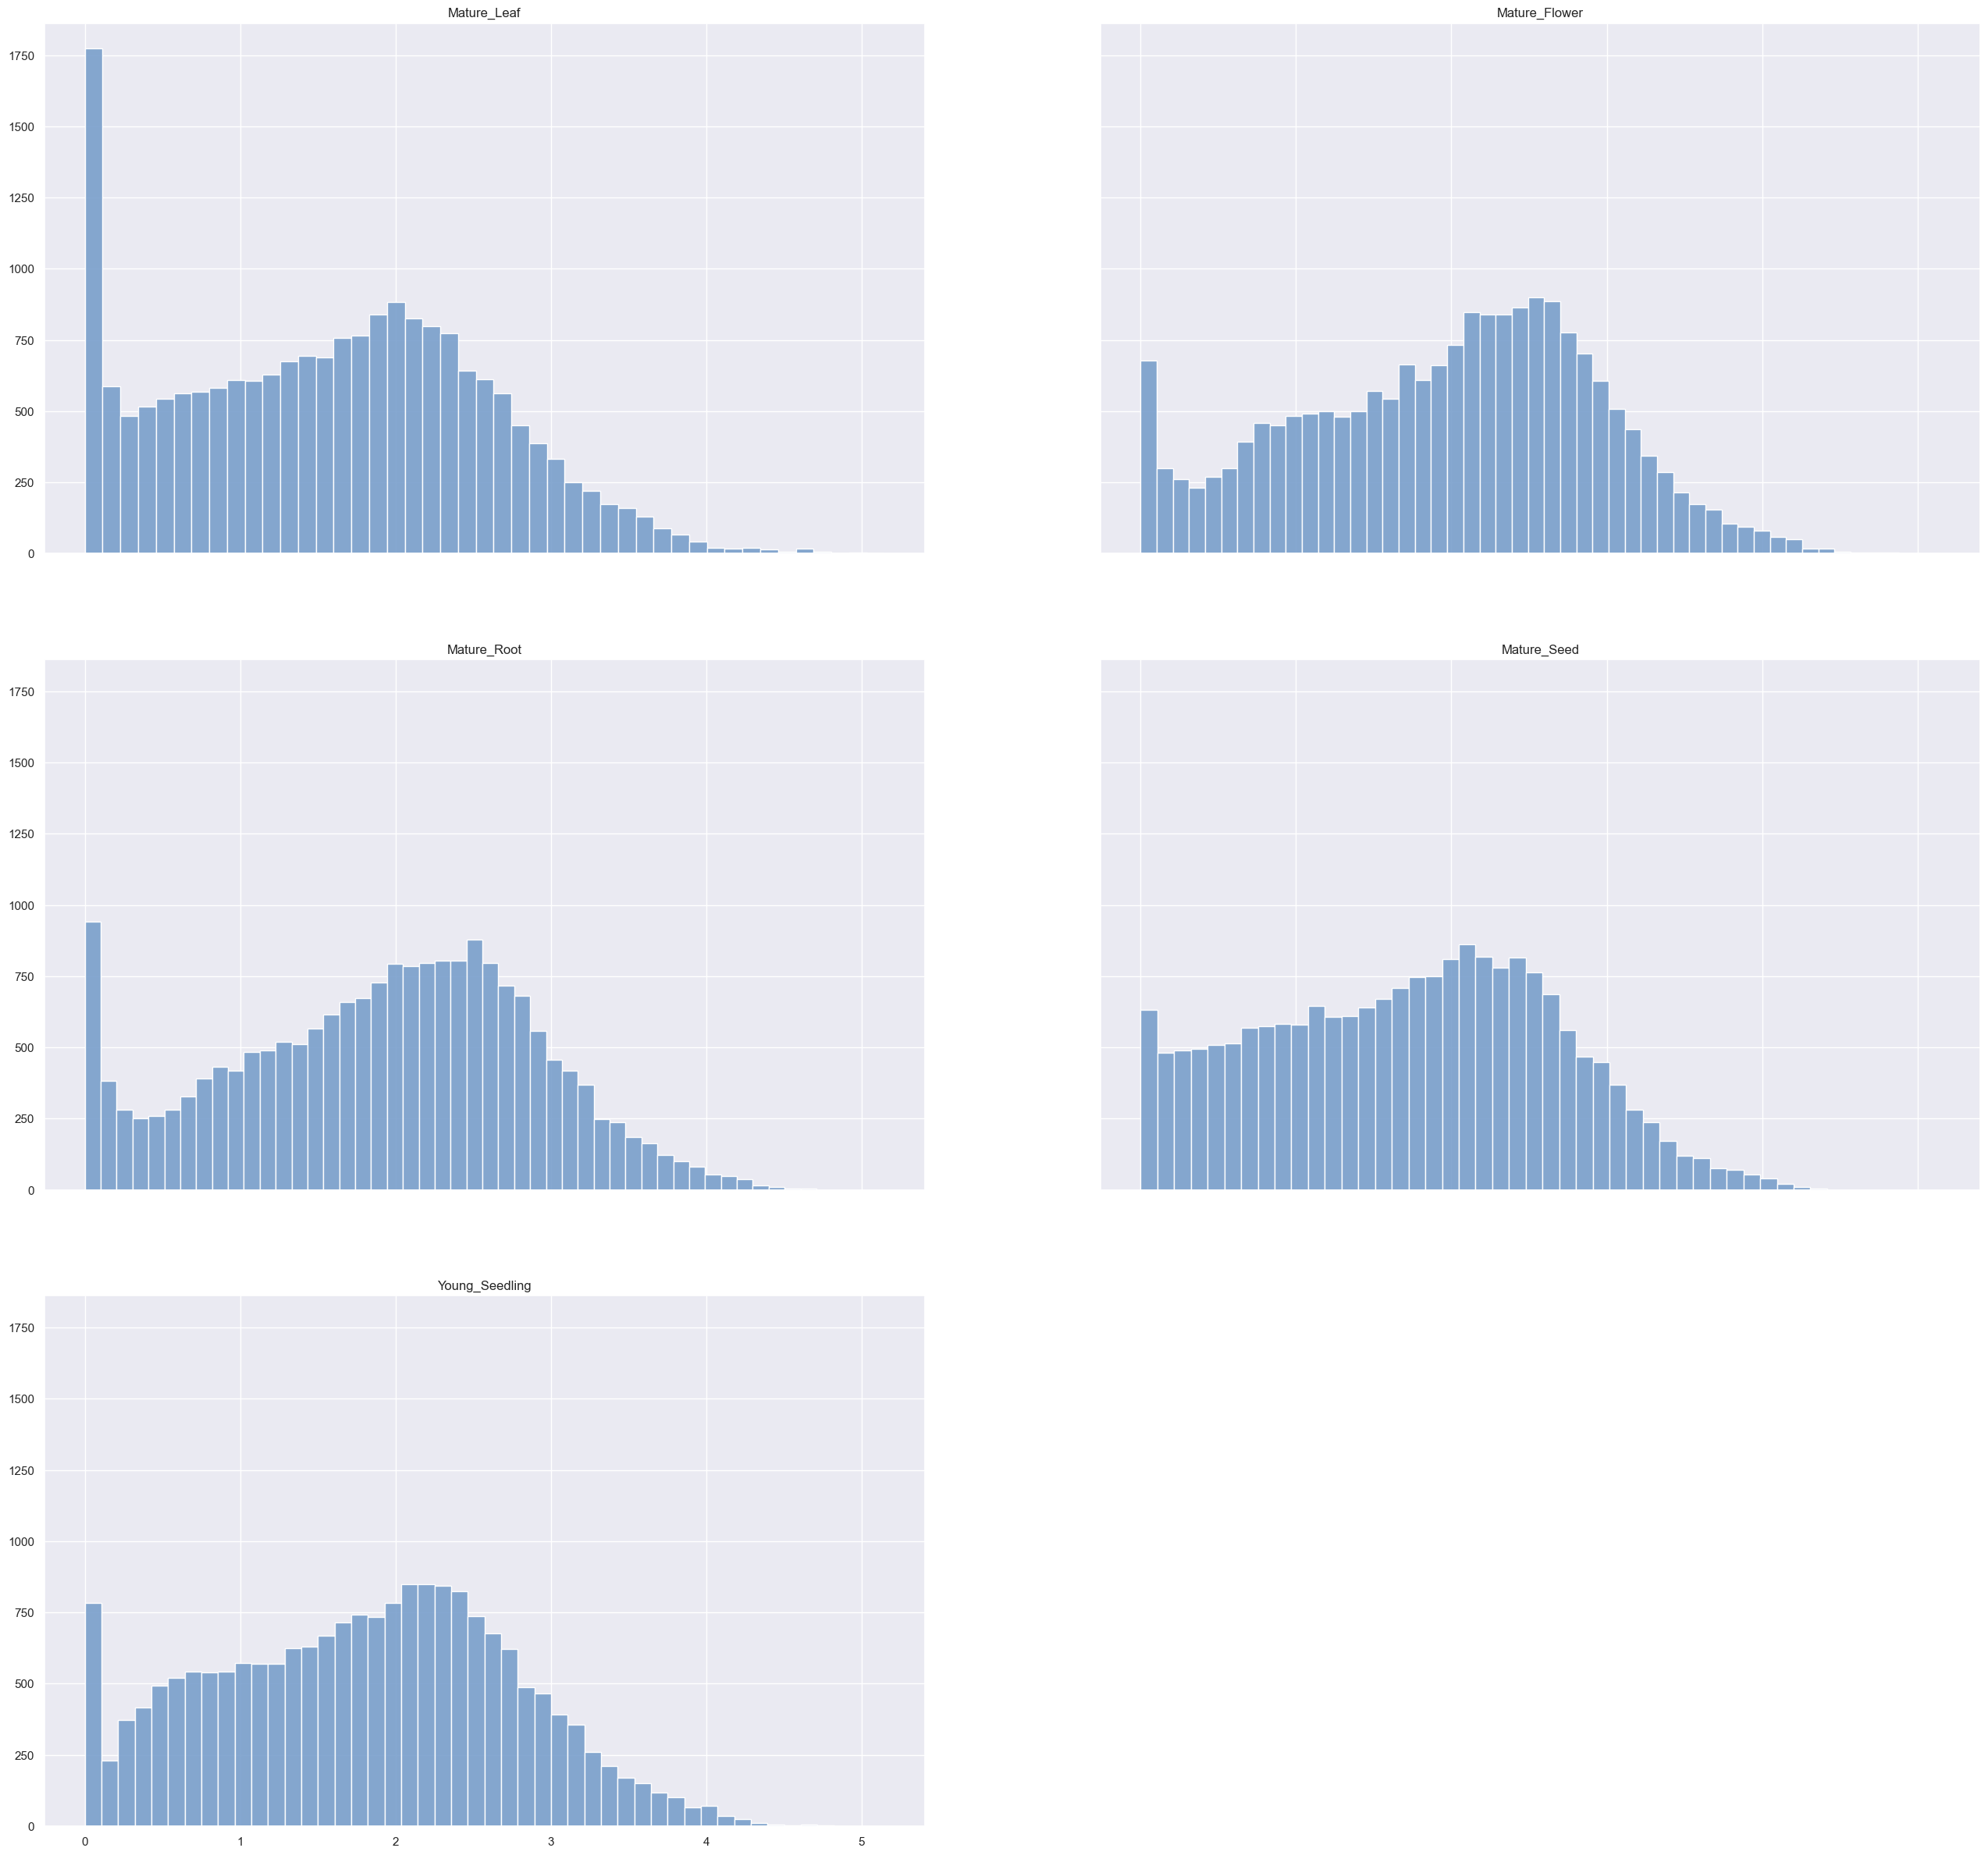

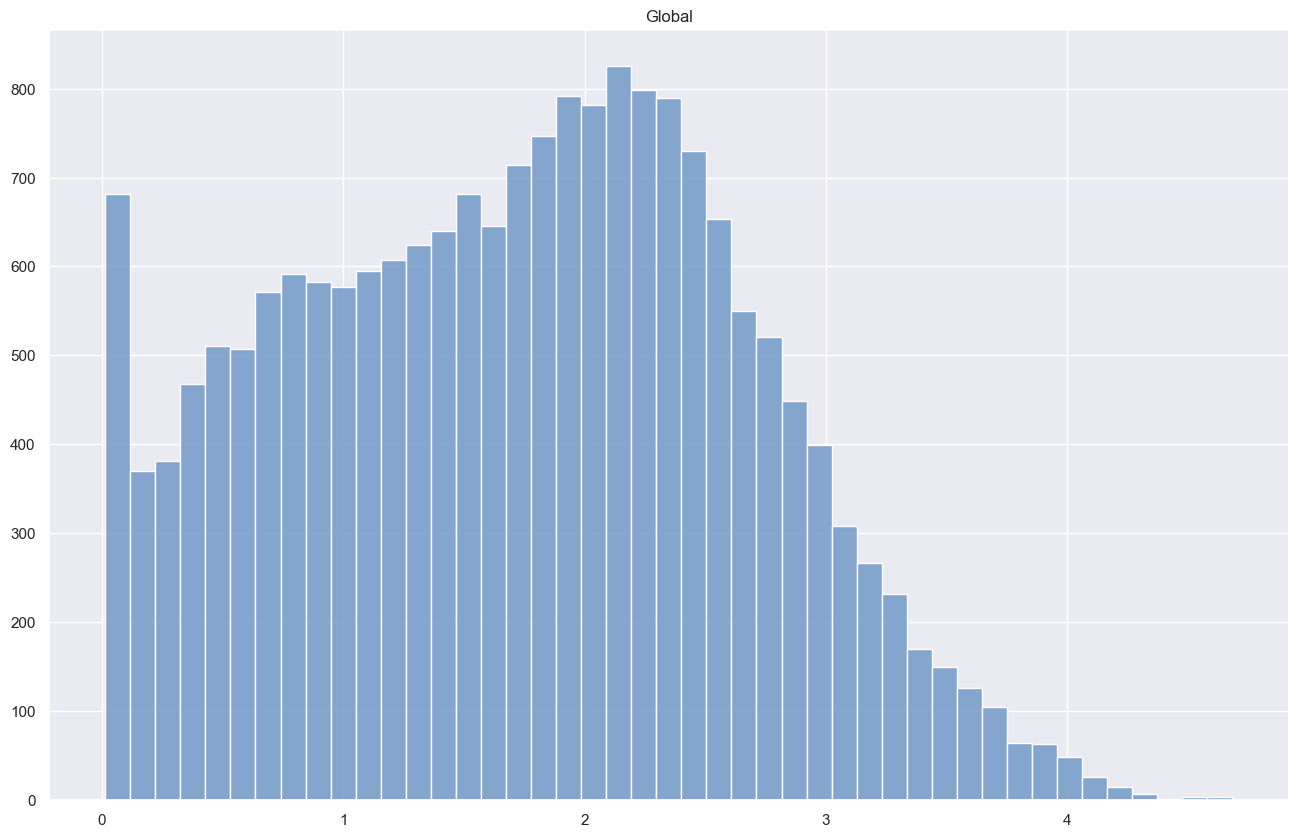

In [12]:
# Compute the regression distribution and display per tissue

distribution = feature_target.distribution_group(
	data   = values,
	order  = order,
	select = 'mean',
	genes  = anndata.var.index.to_list()
)

for group in ['tissue', 'group', 'global'] :
	feature_target.distribution_histplot(
		data     = distribution,
		groupby  = group,
		discrete = False,
		filename = os.path.join(OUT_PLOT, 'distribution-{}-mean'.format(group))
	)

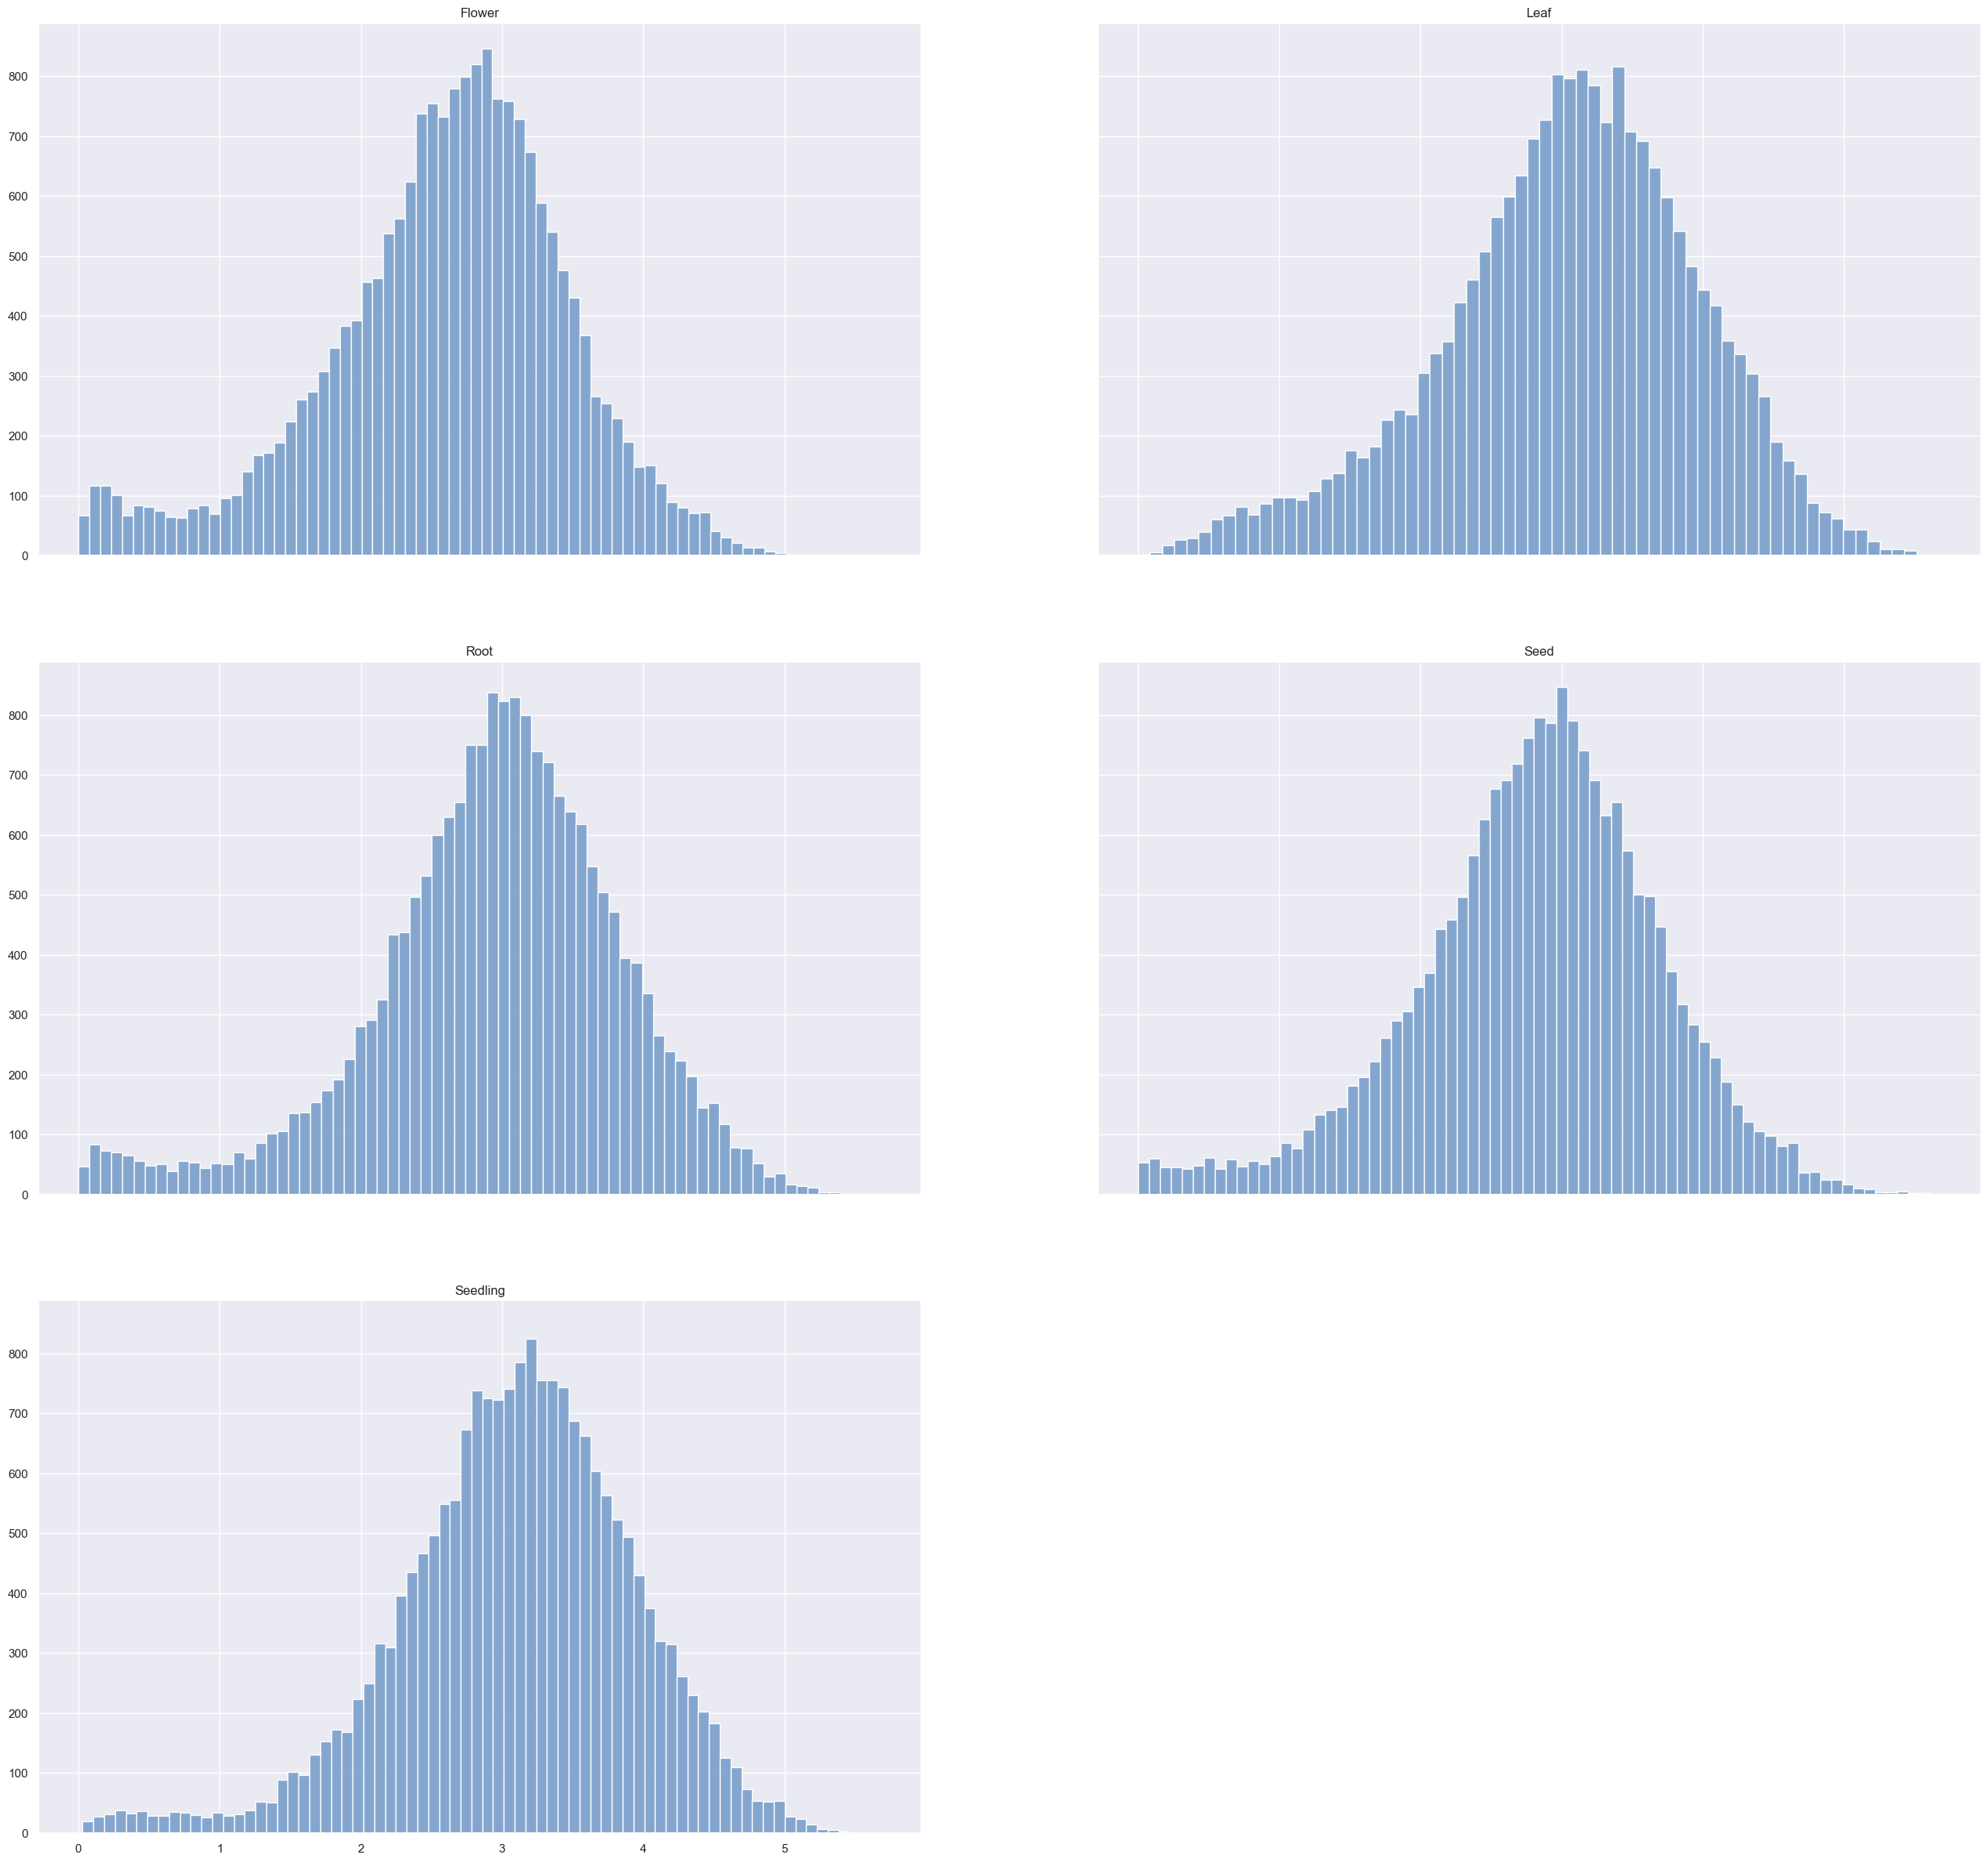

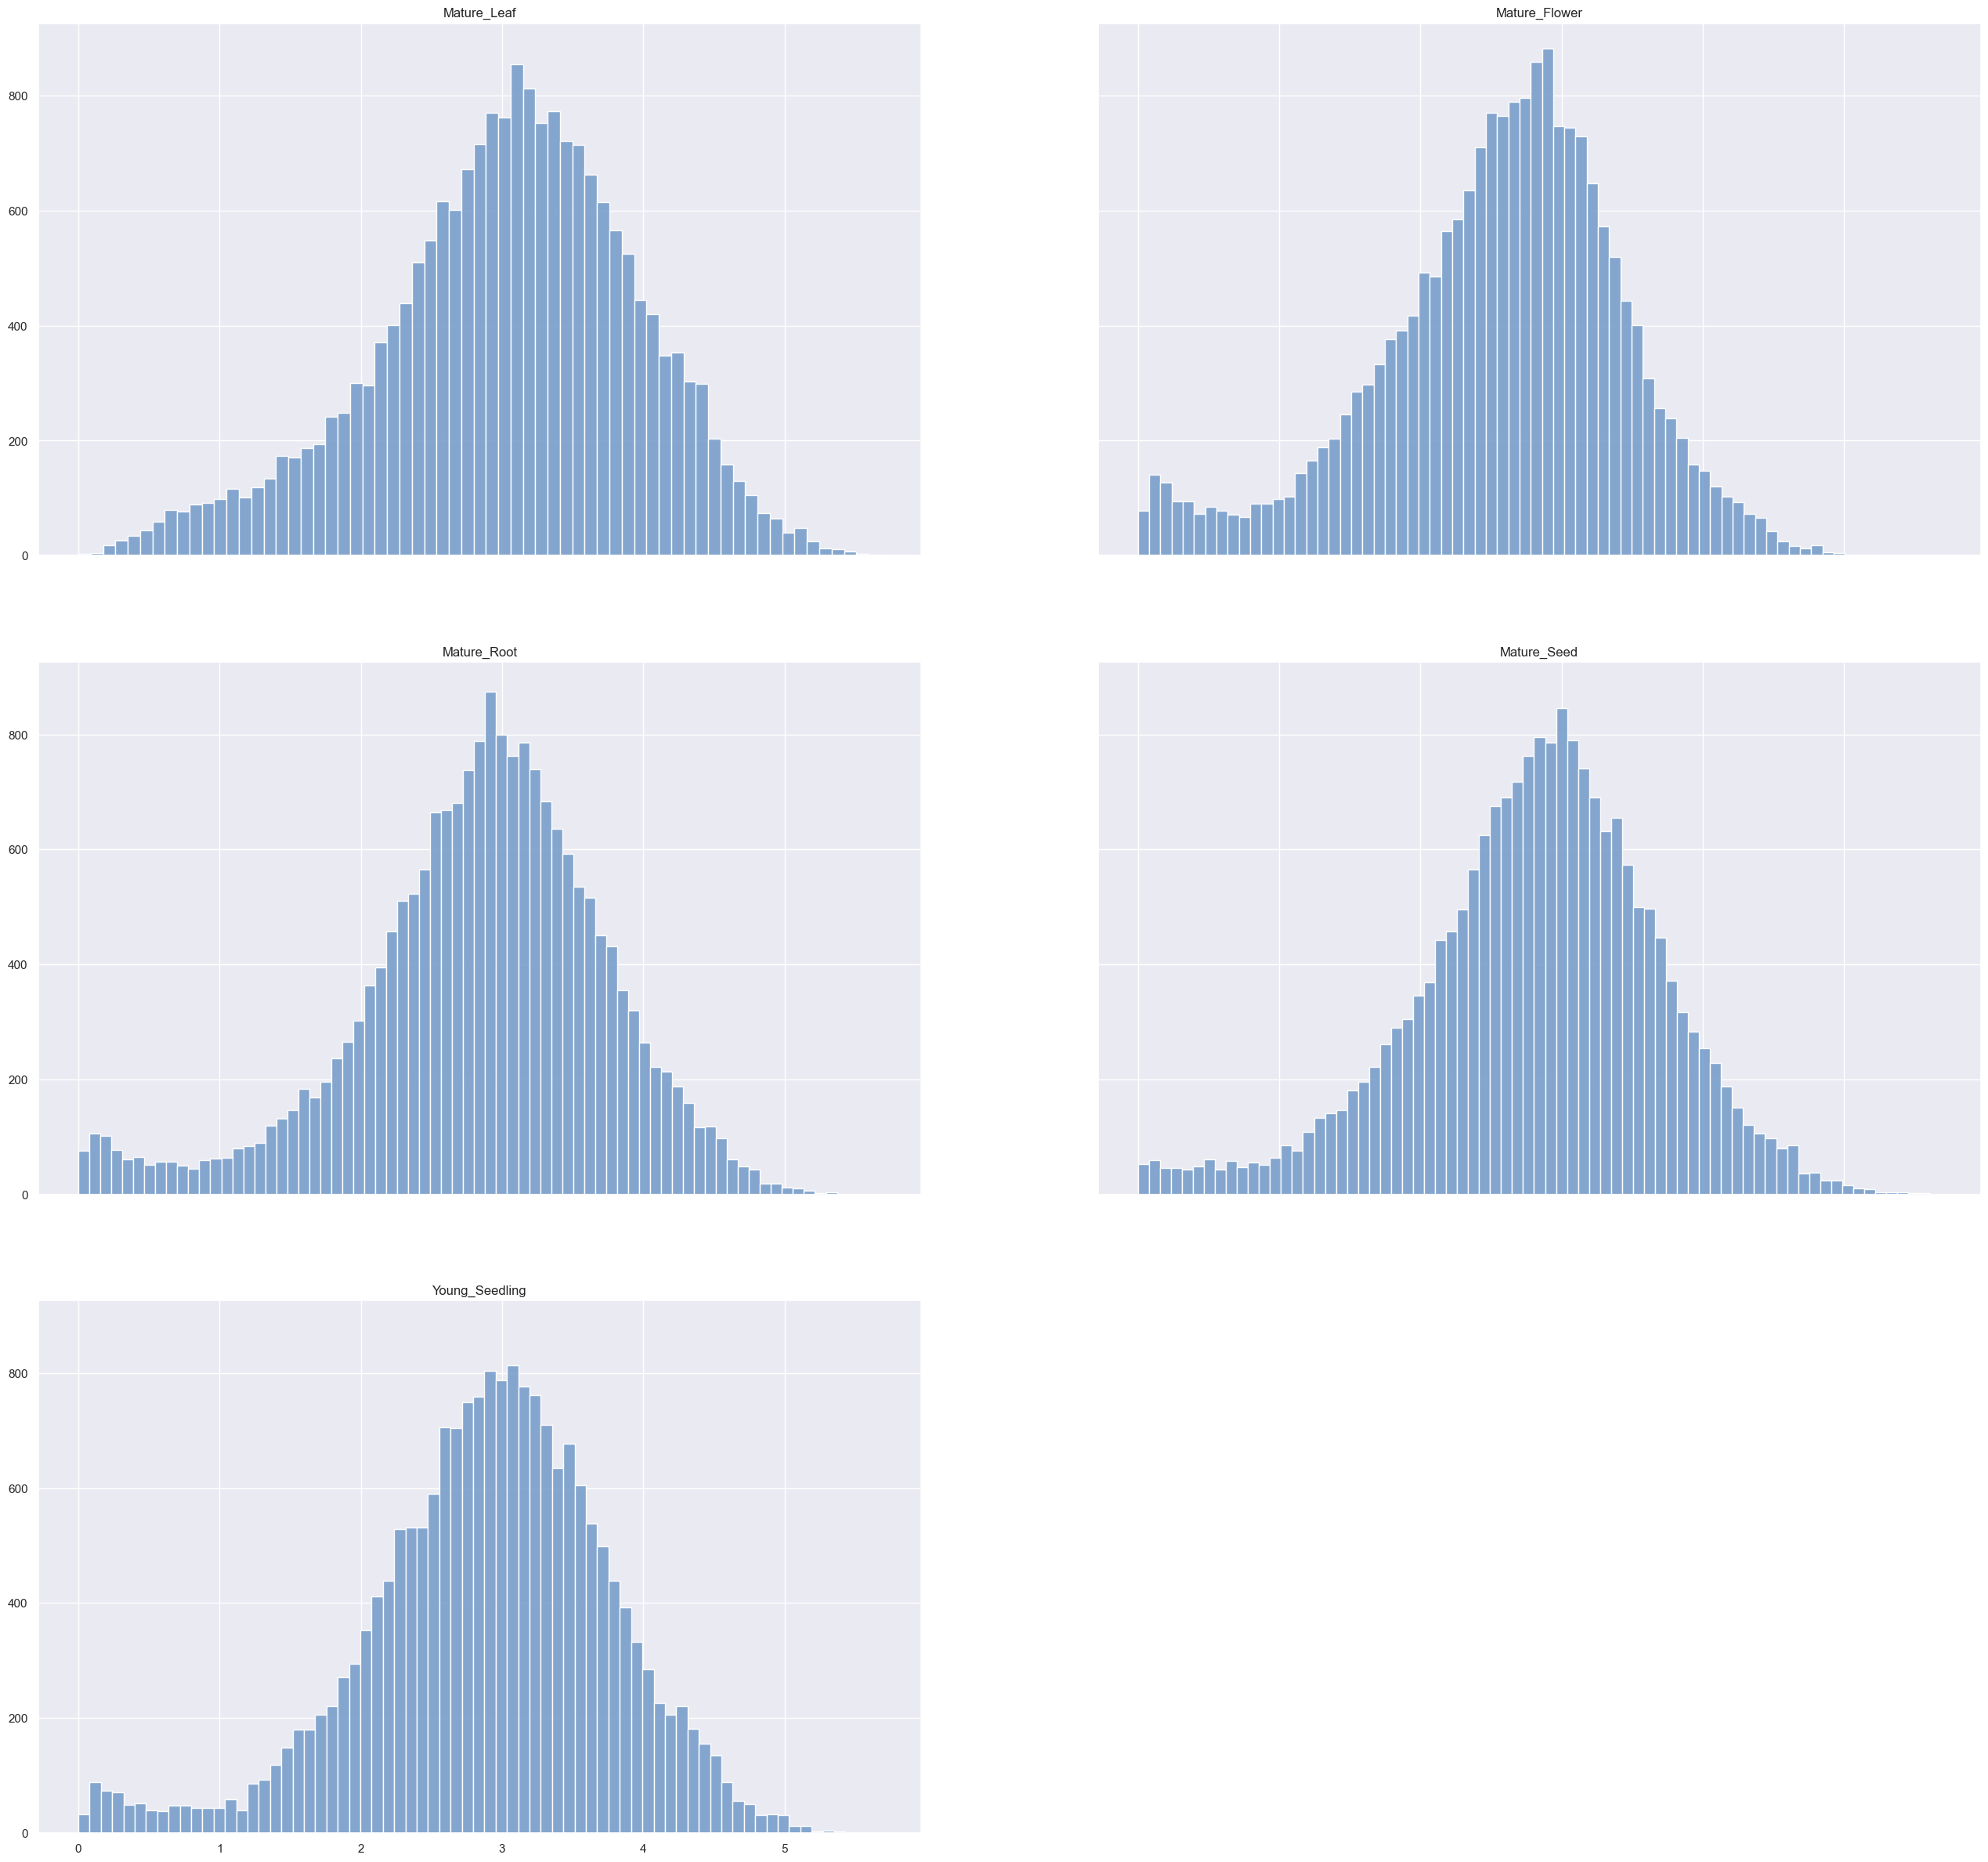

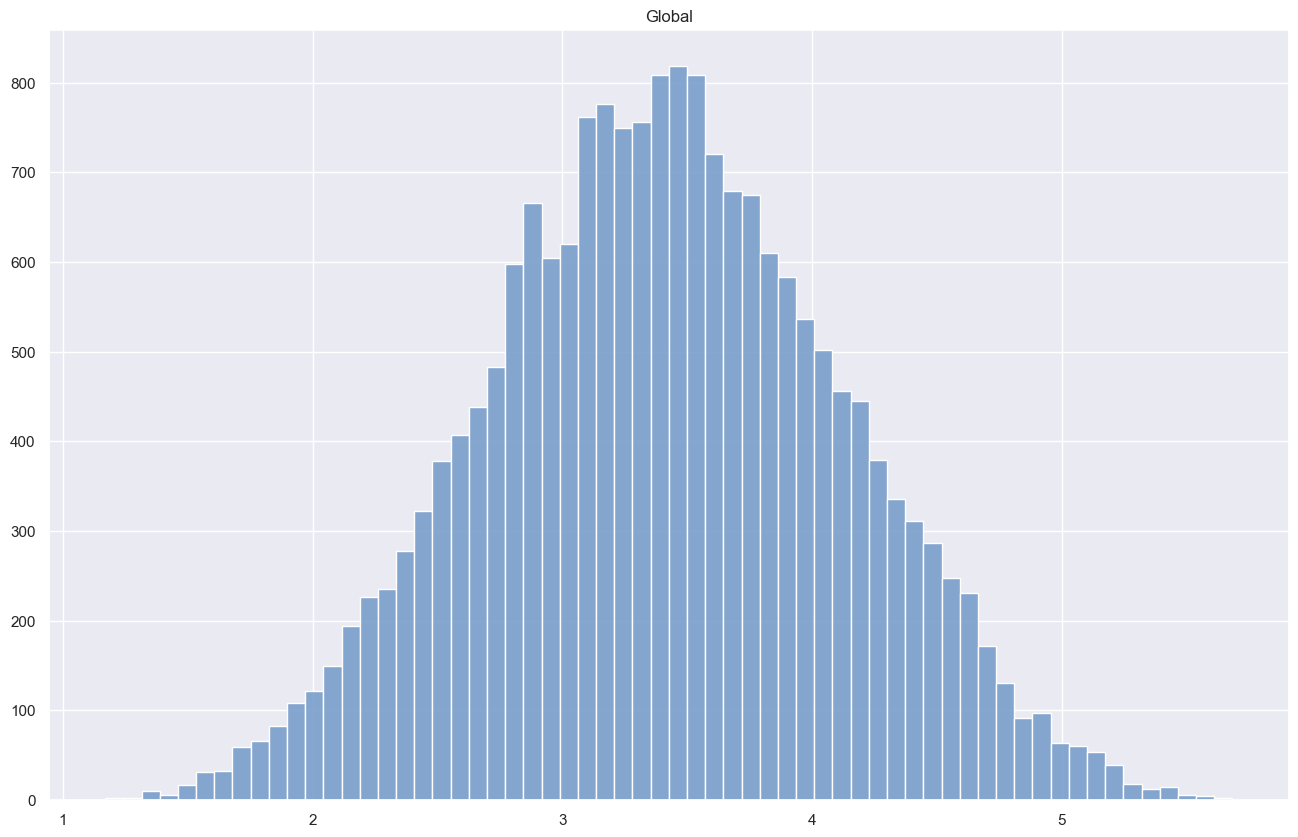

In [13]:
# Compute the regression distribution and display per tissue

distribution = feature_target.distribution_group(
	data   = values,
	order  = order,
	select = 'max',
	genes  = anndata.var.index.to_list()
)

for group in ['tissue', 'group', 'global'] :
	feature_target.distribution_histplot(
		data     = distribution,
		groupby  = group,
		discrete = False,
		filename = os.path.join(OUT_PLOT, 'distribution-{}-max'.format(group))
	)

## 2.2 Save

In [14]:
# Save the target transcript tpm values

writer.write_json(
	data     = values,
	filename = os.path.join(OUT_DATA, 'target-values.json')
)

writer.write_json(
	data     = order,
	filename = os.path.join(OUT_DATA, 'target-order.json')
)

# 3. Classification

In [15]:
# Extract the transcript tpm classification per group (reuses tpm values from regression extraction)

labels, bounds = feature_target.classify_tpm(
	data    = values,
	classes = 3
)

In [16]:
# Display bounds in different configurations (start, values and mapping are manually set based on nbp02-anndata)

feature_target.display_bounds_mapping(
	bounds     = bounds['tissue-mean'],
	start      = TARGET_LAYER,
	values = {
		'min_value'  : factor_normal['min'],
		'max_value'  : factor_normal['max'],
		'box_lambda' : factor_boxcox['lambda'],
		'log_base'   : 2
	},
	mapping = mapping_layer
)

                             boxcox1p |                           tpm
---------------------------------------------------------------------
level-0       0.00022 -       1.34548 |       0.00022 -       3.47004
level-1       1.34548 -       2.29749 |       3.47004 -      15.38936
level-2       2.29749 -       5.14392 |      15.38936 -  13,186.87068


In [17]:
# Display an example of the transcript classification

gene = anndata.var.index.to_list()[0]

for index, (key, value) in enumerate(labels[gene].items()) :
	print(f'{key:17s} : [{len(value):2d}] ' + ' '.join('{:1d}'.format(x) for x in value))

tissue-max        : [ 5] 0 2 2 1 2
tissue-mean       : [ 5] 1 1 2 1 1
age-max           : [ 4] 1 1 0 2
age-mean          : [ 4] 1 1 1 1
group-max         : [ 5] 1 1 2 1 2
group-mean        : [ 5] 0 1 2 1 1
perturbation-max  : [ 7] 2 1 1 1 1 1 1
perturbation-mean : [ 7] 1 1 2 1 1 1 1
global-mean       : [ 1] 1
global-max        : [ 1] 1


## 3.1 Distributions

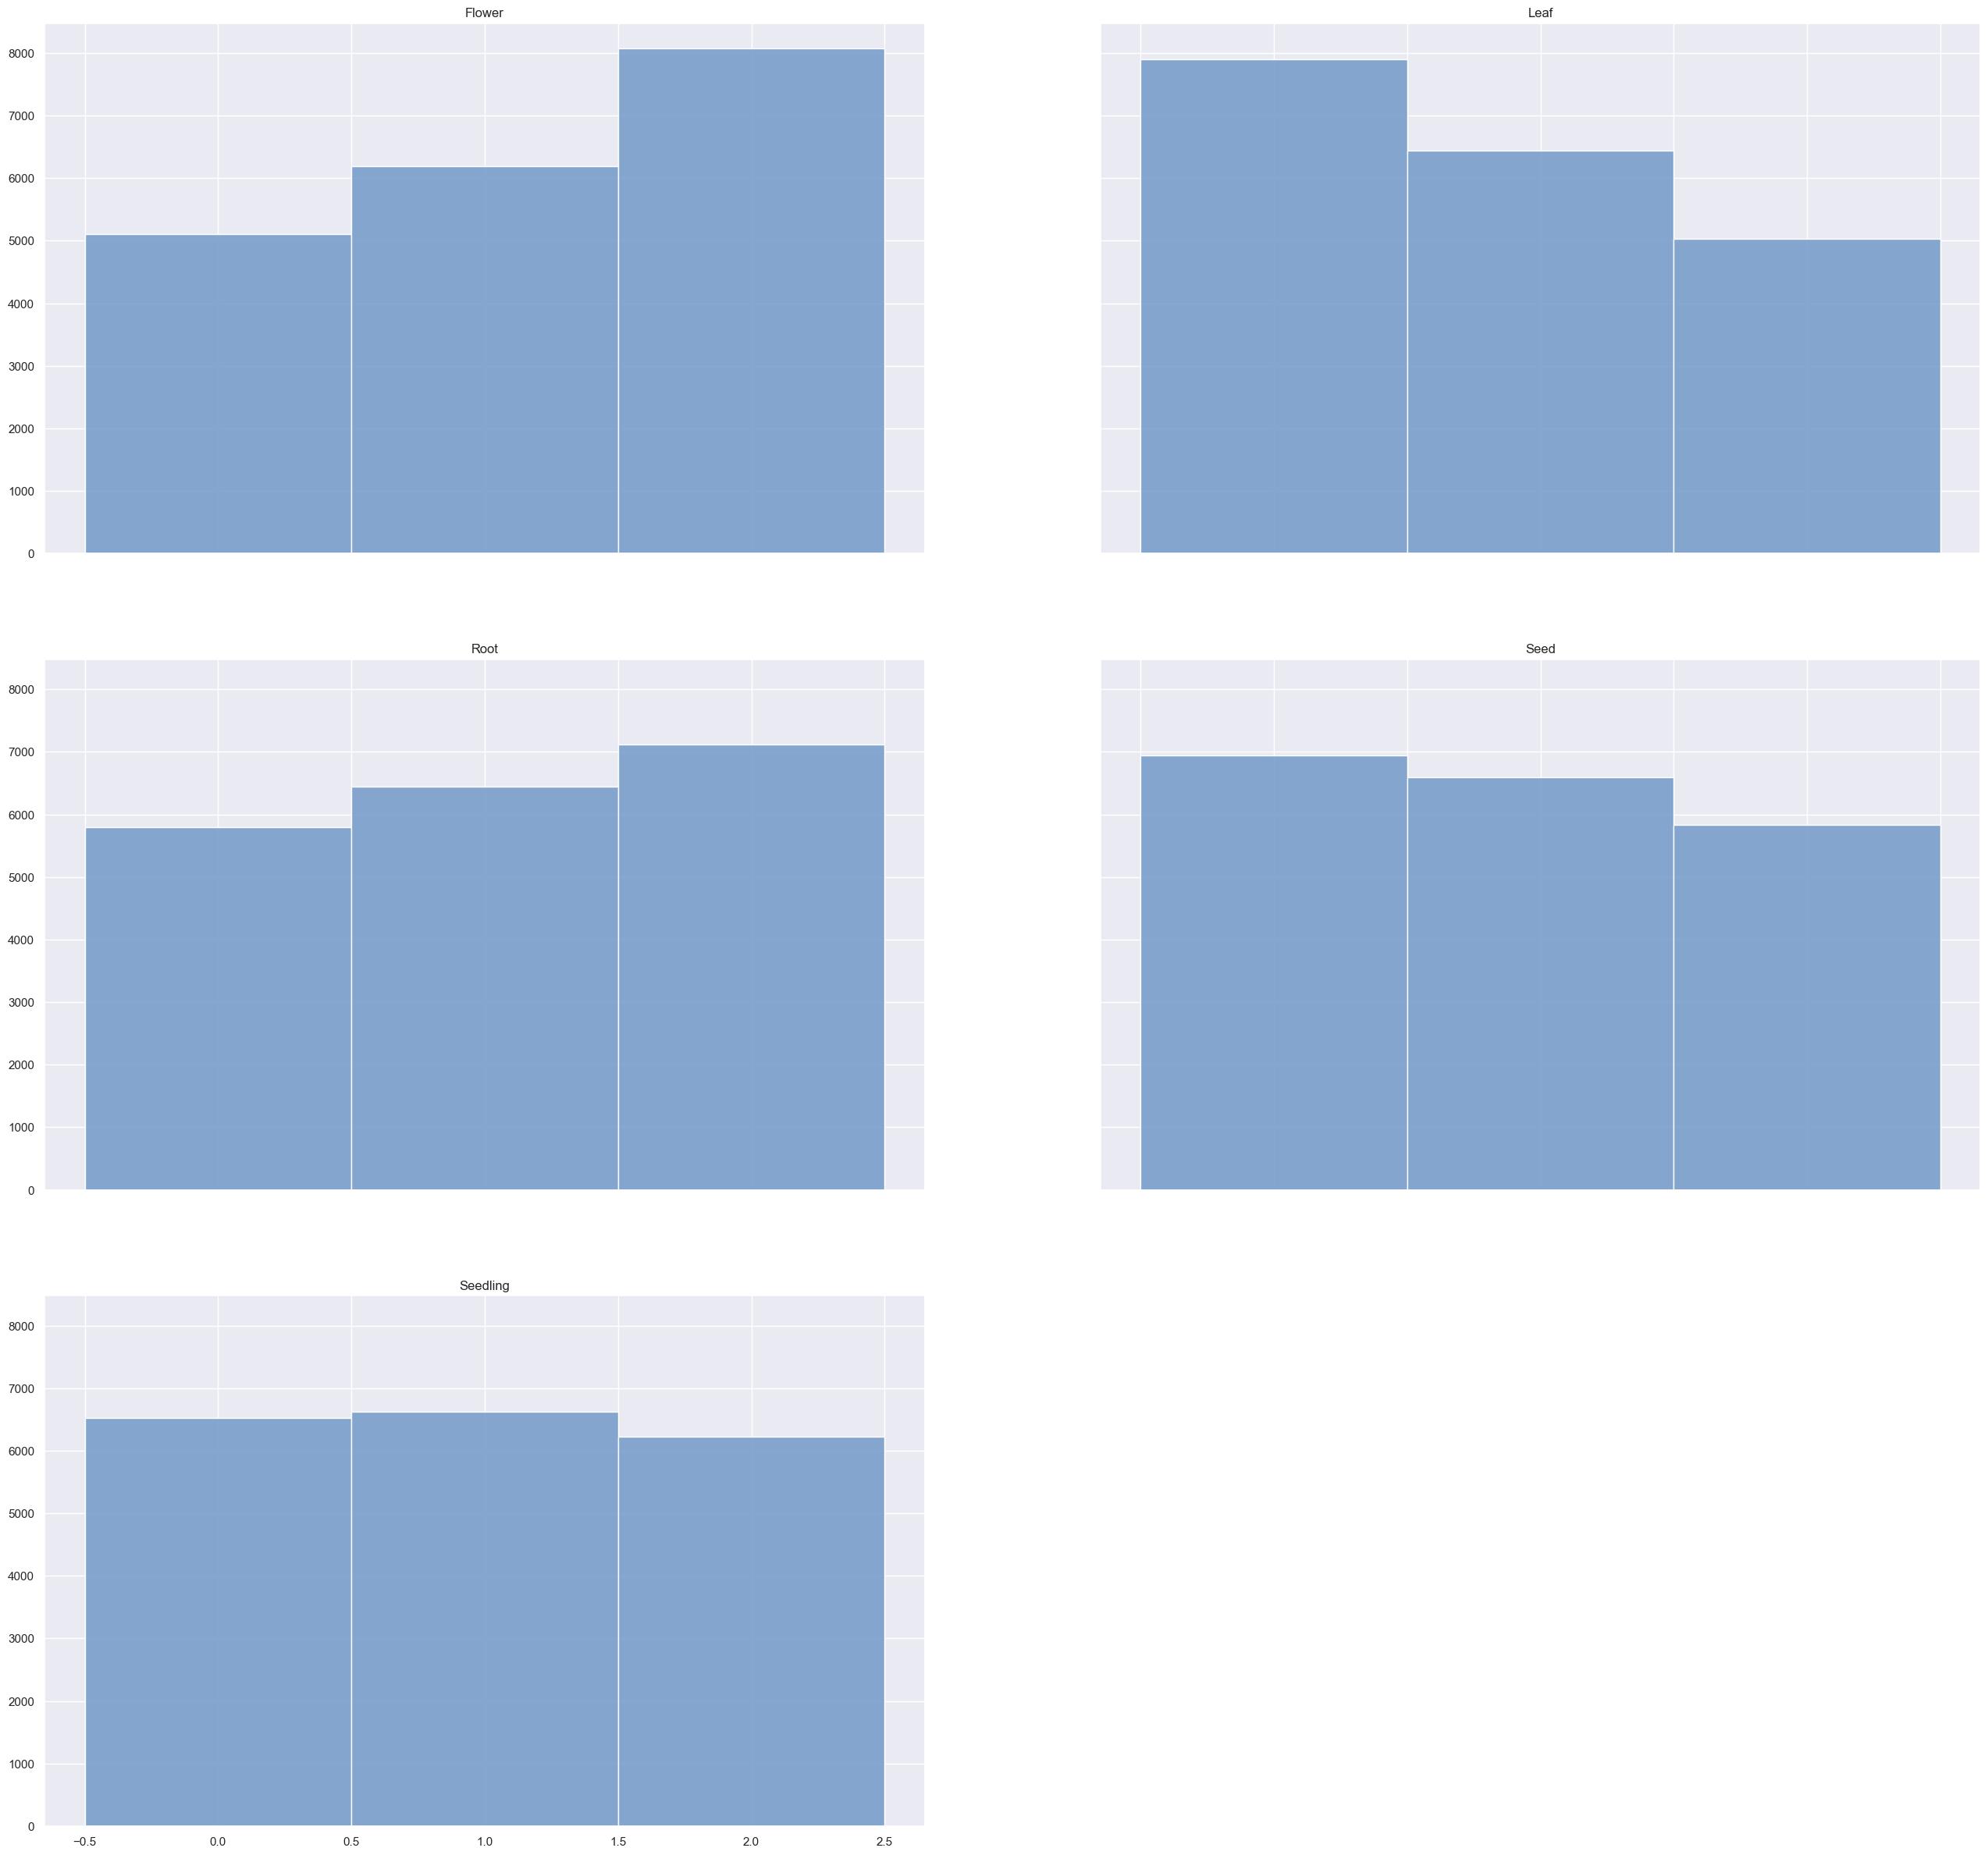

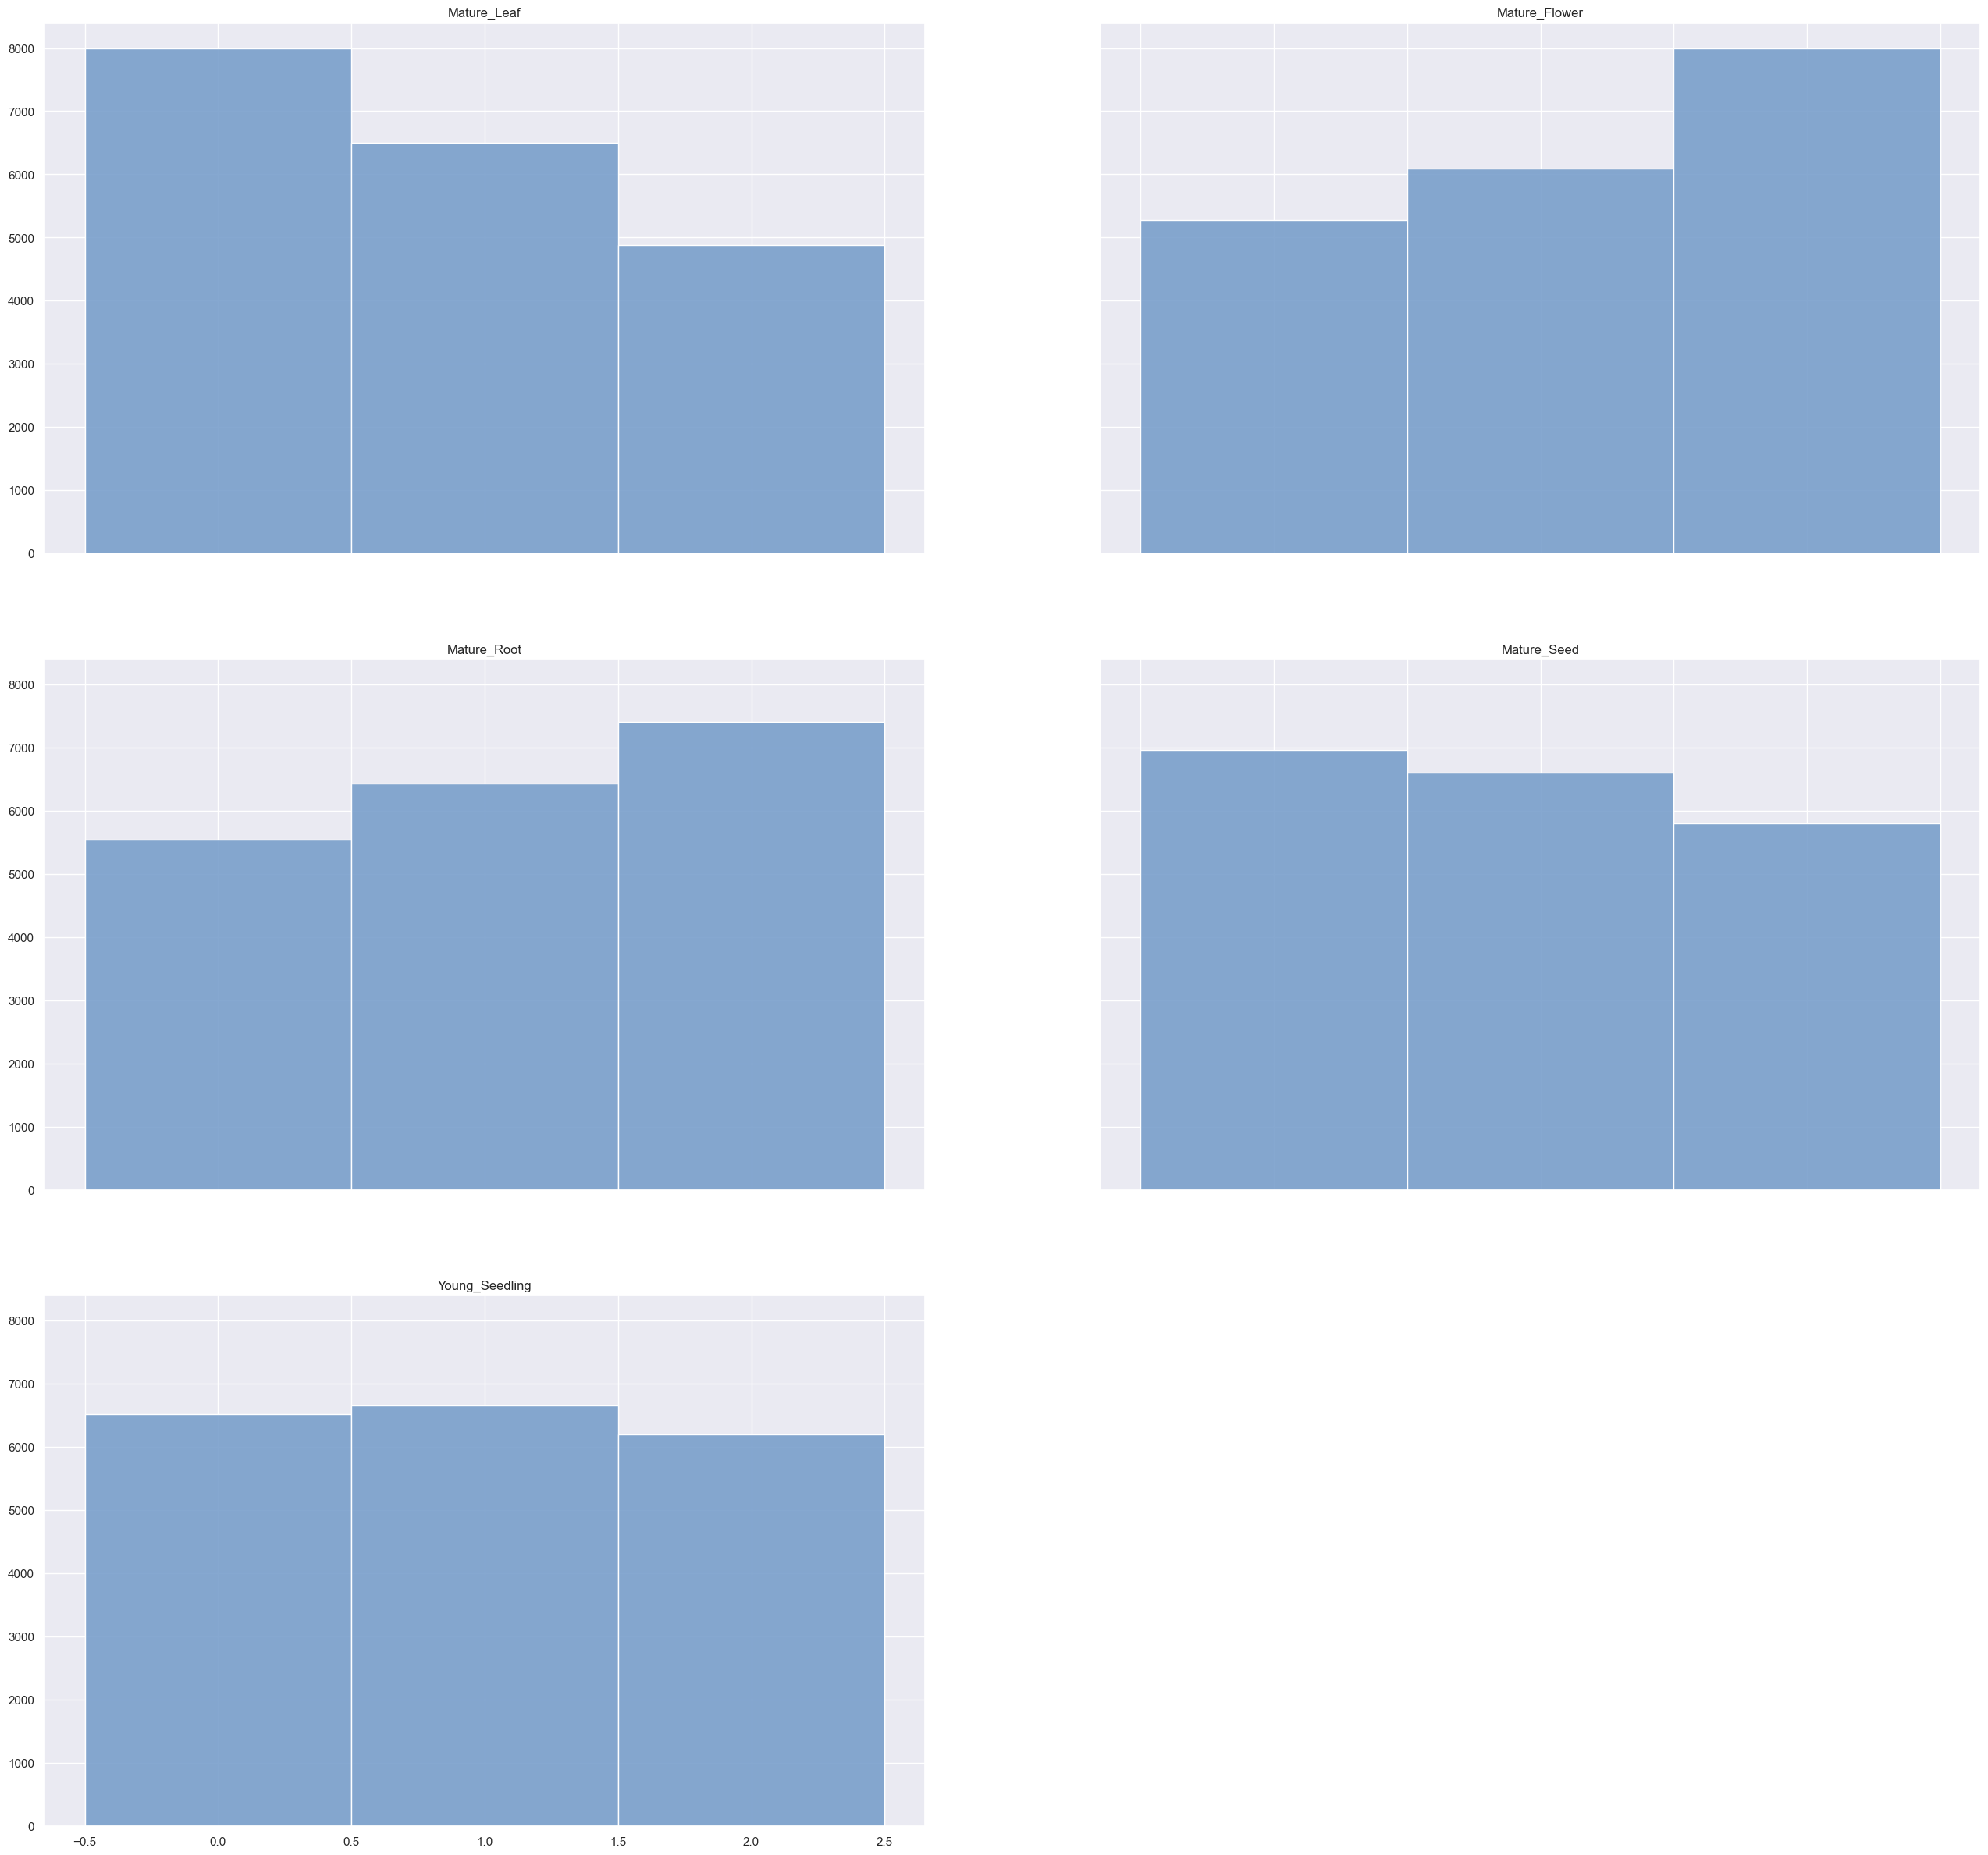

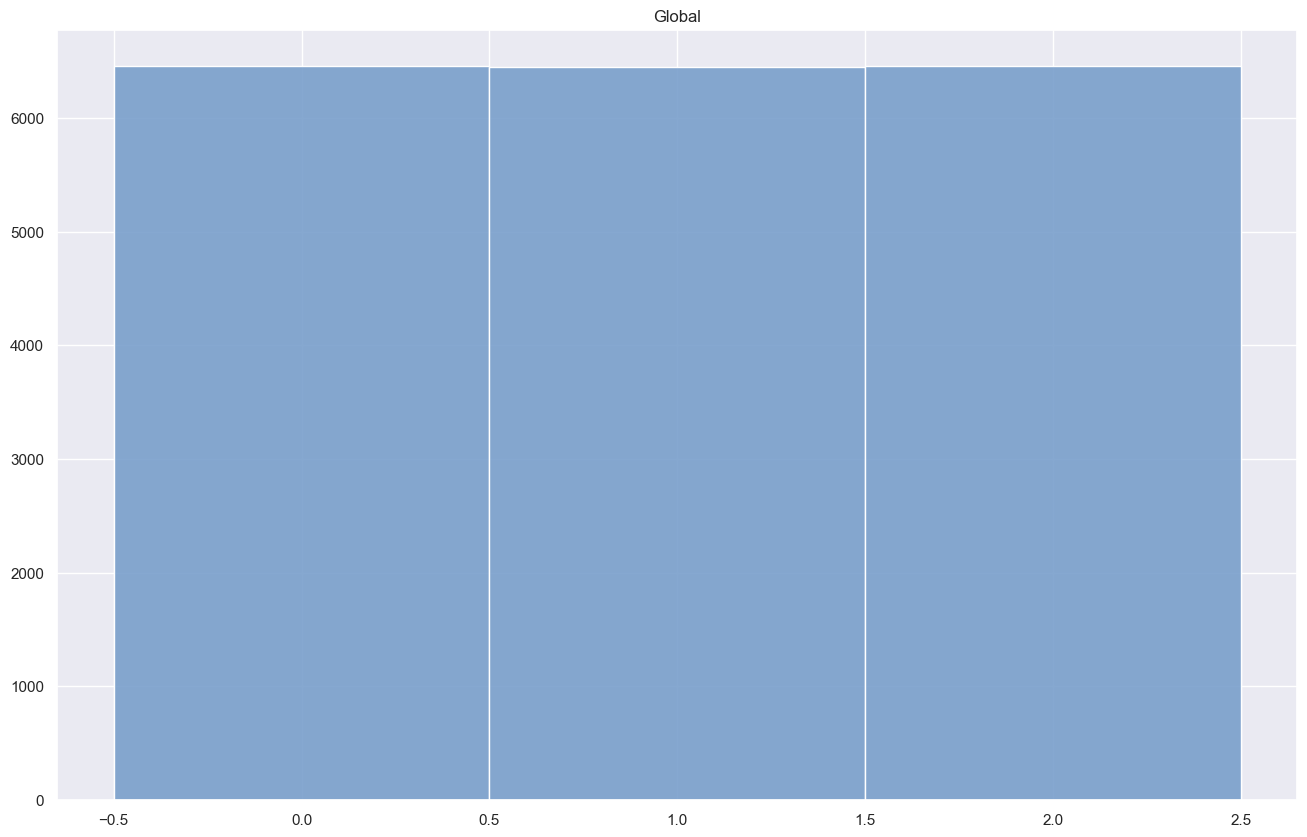

In [18]:
# Compute the classification distribution and display per tissue

distribution = feature_target.distribution_group(
	data   = labels,
	order  = order,
	select = 'mean',
	genes  = anndata.var.index.to_list()
)

for group in ['tissue', 'group', 'global'] :
	feature_target.distribution_histplot(
		data     = distribution,
		groupby  = group,
		discrete = True,
		filename = os.path.join(OUT_PLOT, 'distribution-{}-mean-class'.format(group))
	)

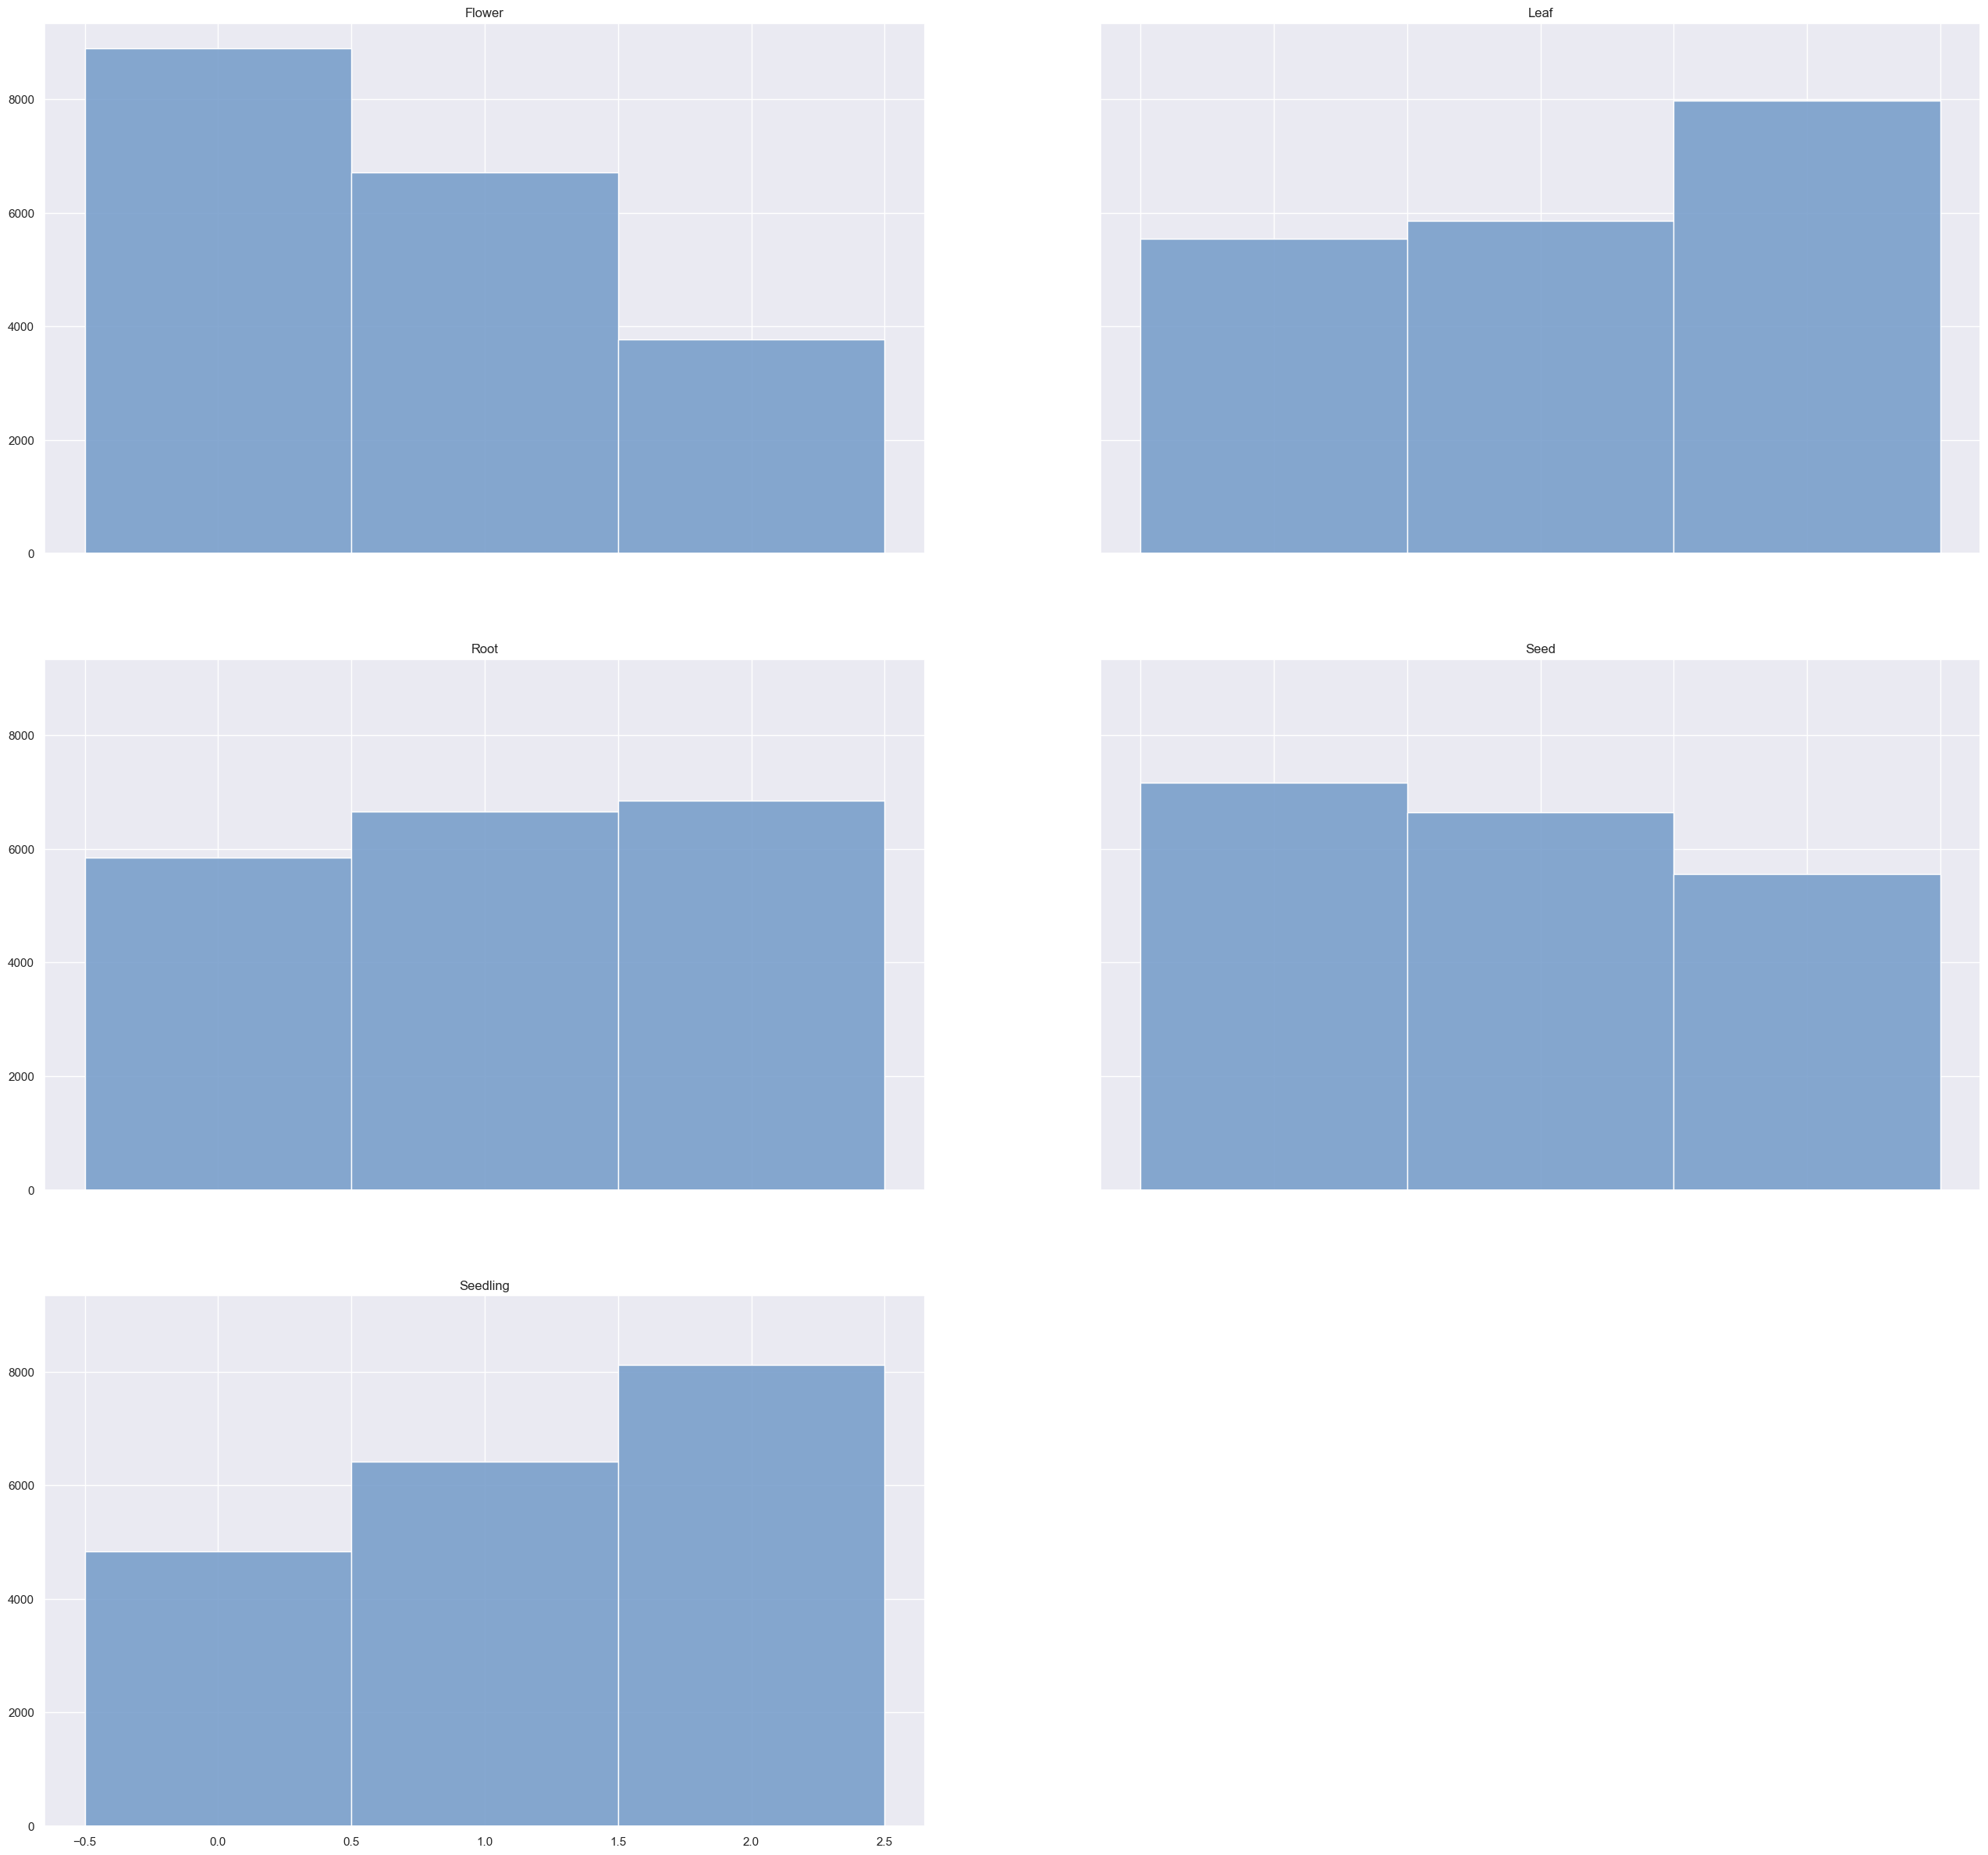

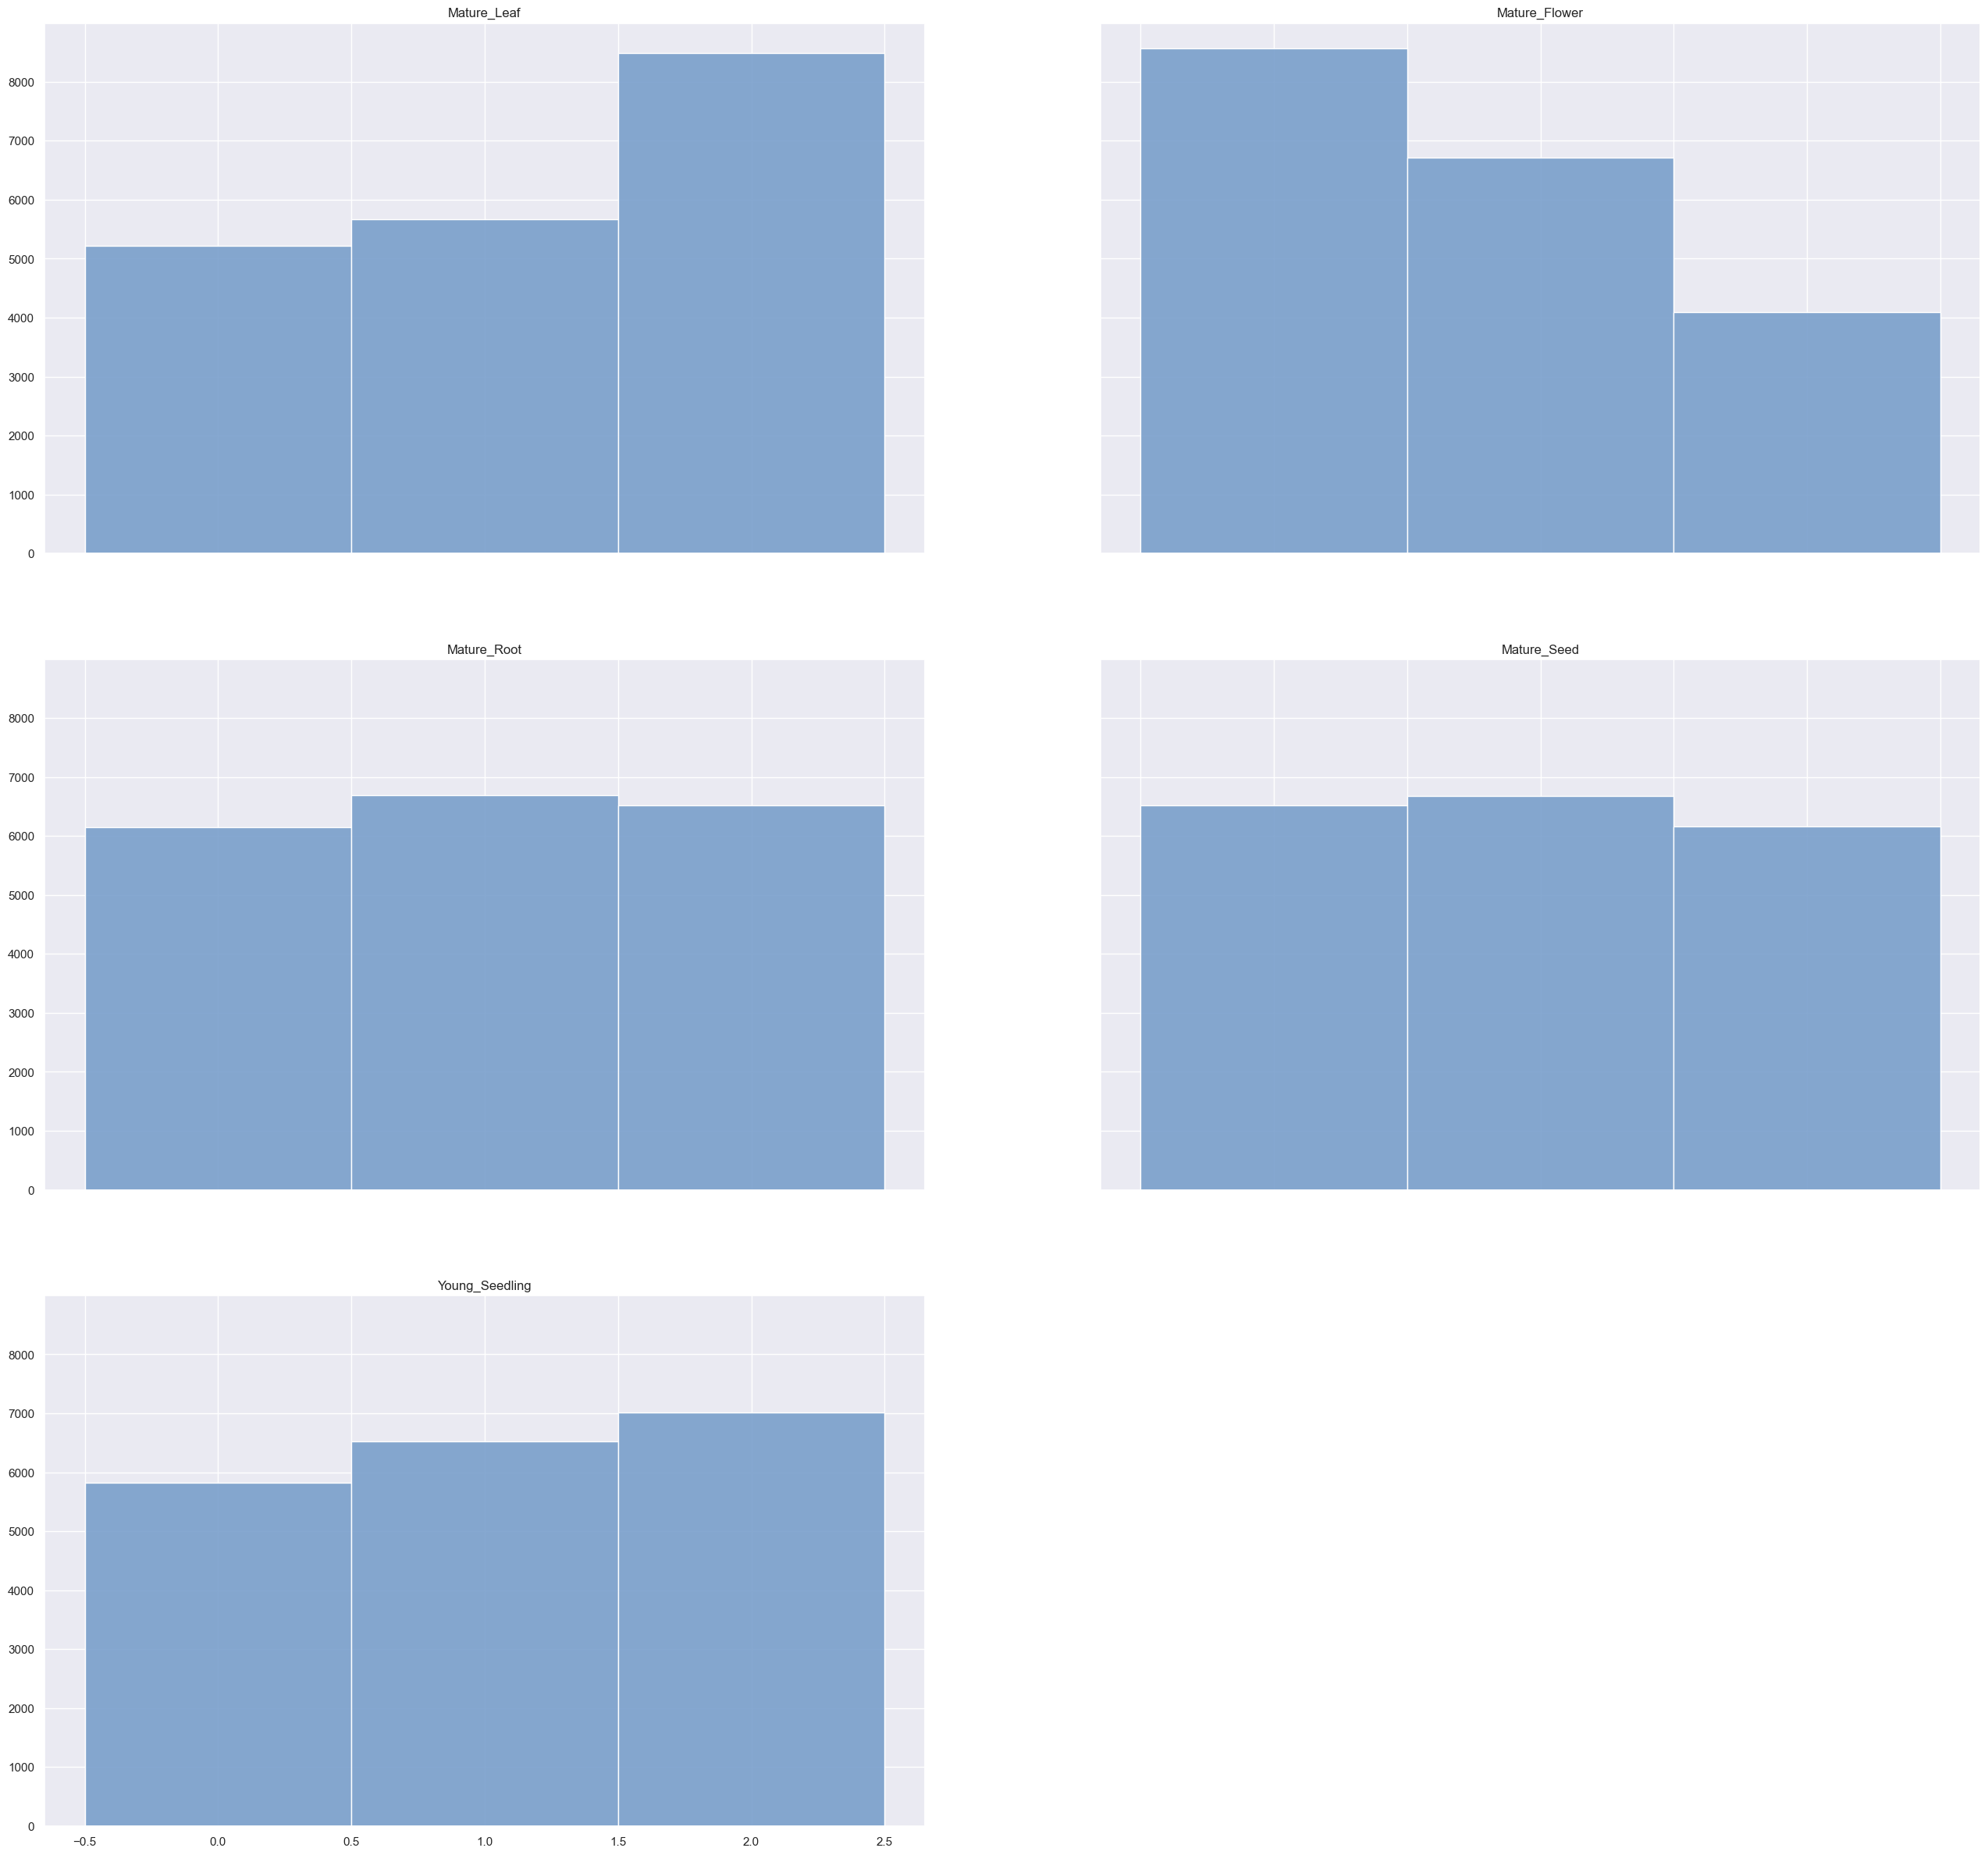

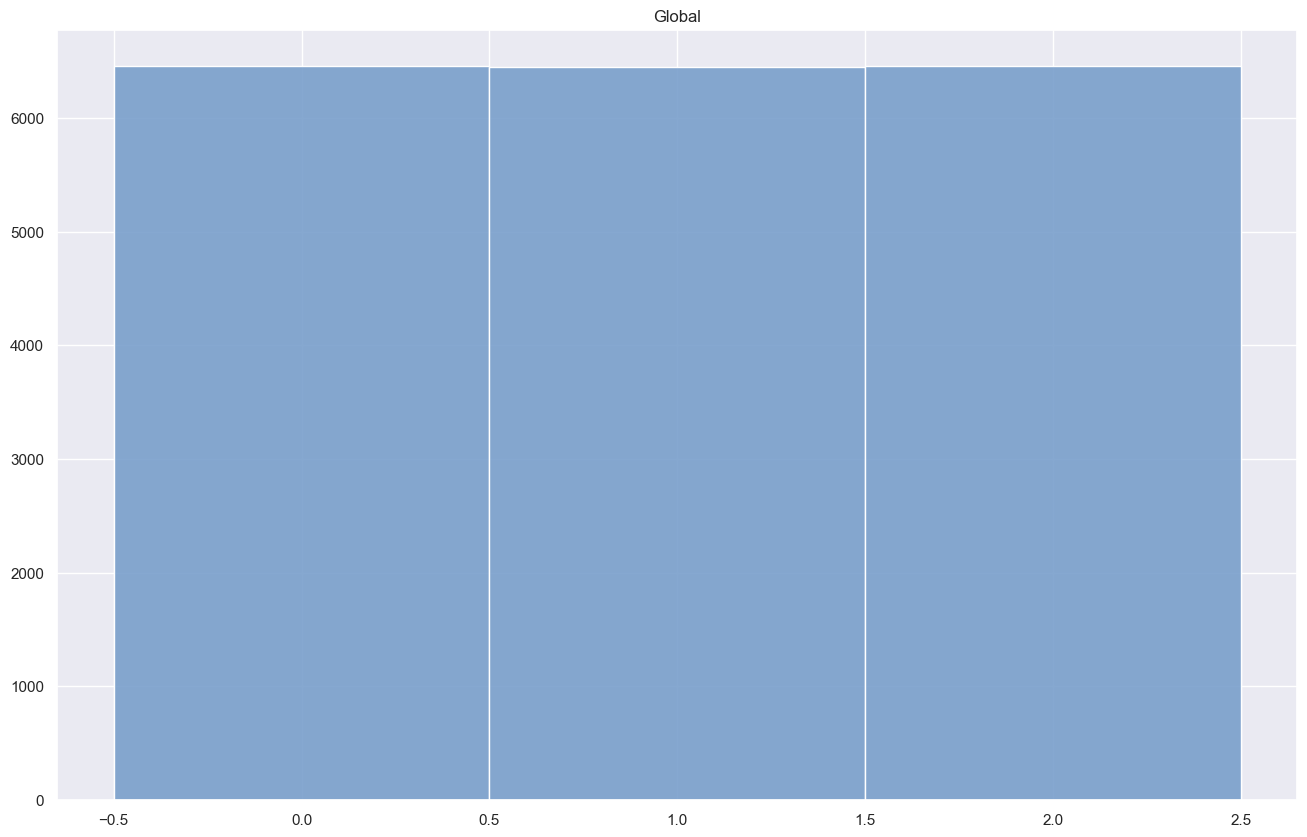

In [19]:
# Compute the classification distribution and display per tissue

distribution = feature_target.distribution_group(
	data   = labels,
	order  = order,
	select = 'max',
	genes  = anndata.var.index.to_list()
)

for group in ['tissue', 'group', 'global'] :
	feature_target.distribution_histplot(
		data     = distribution,
		groupby  = group,
		discrete = True,
		filename = os.path.join(OUT_PLOT, 'distribution-{}-max-class'.format(group))
	)

## 3.2 Save

In [20]:
# Save the target transcript classification

writer.write_json(
	data     = labels,
	filename = os.path.join(OUT_DATA, 'target-labels.json')
)

# 4. Mapping

In [21]:
# Create binarizers and mapping lookup

features_binarizer, features_grouped, features_exploded = feature_target.create_mapping(
	values = values,
	labels = labels,
	order  = order
)

In [22]:
# Show keys and labels

for key in features_binarizer.keys() :
	classes = features_binarizer[key].classes_

	if len(classes) > 8 :
		print('{:17s} : {} ...'.format(key, classes[:8]))
	else :
		print('{:17s} : {}'.format(key, classes))

tissue-mean       : ['flower' 'leaf' 'root' 'seed' 'seedling']
tissue-max        : ['flower' 'leaf' 'root' 'seed' 'seedling']
age-mean          : ['mature' 'missing' 'seed' 'young']
age-max           : ['mature' 'missing' 'seed' 'young']
group-mean        : ['mature_flower' 'mature_leaf' 'mature_root' 'mature_seed' 'young_seedling']
group-max         : ['mature_flower' 'mature_leaf' 'mature_root' 'mature_seed' 'young_seedling']
perturbation-mean : ['chemical' 'control' 'dna' 'environmental' 'mechanical' 'mutant' 'unstressed']
perturbation-max  : ['chemical' 'control' 'dna' 'environmental' 'mechanical' 'mutant' 'unstressed']
global-mean       : ['global']
global-max        : ['global']


In [23]:
# Save binarizers and mapping lookup

writer.write_pickle(
	data     = features_grouped,
	filename = os.path.join(OUT_DATA, f'mapping-grouped.pkl')
)

writer.write_pickle(
	data     = features_exploded,
	filename = os.path.join(OUT_DATA, f'mapping-exploded.pkl')
)

# 5. Bert

## 5.1 Transcript (Full)

In [24]:
# Generate full transcript tokens for bert model

generator = lambda : bert_data.data_prepare(
	sequences   = sequence_bp2150,
	features    = feature_base,
	directory   = OUT_DATA,
	valid_split = 0.0,
	test_split  = 0.2
)

for data, filename in generator() :
	bert_data.create_kmers(
		filename     = os.path.join(OUT_DATA, 'dnabert-{}', 'transcript-full', '{}'.format(filename), '{}.tsv'),
		generator    = dataset_split.generate_group_shuffle_split,
		max_tokens   = None,
		random_seed  = RANDOM_SEED,
		data         = data
	)

## 5.3 Promoter (512)

In [25]:
# Generate 512 promoter tokens for bert model

generator = lambda : bert_data.data_prepare(
	sequences   = sequence_promoter,
	features    = feature_base,
	directory   = OUT_DATA,
	valid_split = 0.0,
	test_split  = 0.2
)

for data, filename in generator() :
	bert_data.create_kmers(
		filename     = os.path.join(OUT_DATA, 'dnabert-{}', 'promoter-512', '{}'.format(filename), '{}.tsv'),
		generator    = dataset_split.generate_group_shuffle_split,
		max_tokens   = -512,
		random_seed  = RANDOM_SEED,
		data         = data
	)